In [ ]:
import gym
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import math
from scipy.special import softmax
import tensorflow_probability as tfp

#SEED 2 UEs
tf.random.set_seed(12)
np.random.seed(22)

gamma_dqn = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size_dqn = 32  # Size of batch taken from replay buffer


# connect to 5 - random amounts
'''
dict_actions = {
    "0": [0.  ,   0.19074129, 0.23633142, 0.2256996,  0.20456269, 0., 0.142665   ,0. ,0.  ,0. ],     #[1 3 4 2 6]
    "1": [0.  ,   0.27189425, 0., 0.17030932, 0.21046934, 0.26938872, 0.,     0. ,  0.07793836, 0.],   # 3 1 5 4 8
    "2": [0.10275102, 0.30264126, 0.,  0.,   0. ,   0., 0., 0.22669452, 0.25906022, 0.10885299],     # [8 7 9 0 1]
    "3": [0.16654872, 0.32358239, 0., 0.03368735, 0.08192548, 0., 0.,  0.,  0.39425605, 0.   ],      # [1 8 0 4 3]
    "4": [0.,   0.,  0.31711721, 0.19388919, 0.,  0.34970154, 0.,  0.,  0.13587448, 0.00341758],      #[5 9 2 8 3]
    "5": [0. ,  0.,   0.17191809, 0.,  0.25712362, 0.23524776, 0.,  0.0499325,  0.28577802, 0. ],    # 4 2 5 7 8
    "6": [0.24856655, 0.27759128, 0.,  0.14852409, 0.3071876,  0.01813048, 0.,   0.,   0.,   0. ],   # 3 5 1 0 4]
    "7": [0.2183542,  0.,   0.,  0.25829537, 0.1073336,  0., 0.2033568 , 0.21266003, 0., 0.  ],      #6 0 4 7 3
    "8": [0. ,  0.,  0.22402612, 0.14459276 , 0.26519119, 0.23269341, 0., 0.13349653, 0. ,   0.],    #  [7 2 3 5 4]
    "9": [0.17358963, 0.,  0.,  0.22797795, 0.,  0.26112856, 0.05295353, 0. , 0.28435033, 0.      ]    # [3 5 6 0 8]
}
'''

# connect to 4 for 10 APs - random amounts
# connect to 4 - random amounts
'''
dict_actions = {
    "0": [0. ,  0.30672732, 0.22149082, 0. ,  0.,   0., 0.34207347, 0.12970839, 0.,    0. ],  #2 7 1 6
    "1": [0., 0.37190641, 0., 0.00255166, 0., 0., 0.,  0., 0.28054312, 0.34499881], #1 4 8 9
    "2": [0.06642009, 0. ,   0.14315798, 0. , 0.3982394,  0., 0.  ,   0.39218253, 0. ,        0.        ], #0 4 2 7
    "3": [0.38996323, 0. ,  0.23200215, 0.  ,       0. ,        0.07947499, 0. ,   0. ,    0. ,   0.29855963], #2 0 9 5
    "4": [0.32024535, 0.13377763, 0.,  0.31586558, 0.,  0.23011145, 0.,  0.,  0.,  0.        ], #5 3 0 1
    "5": [0.21920769, 0.,  0. ,   0.  ,  0.33133828, 0., 0.35642668, 0. ,  0.09302734, 0.   ], # 0 8 4 6
    "6": [0.32075518, 0., 0.03171573, 0.54554279, 0.,   0., 0.,   0.,   0.1019863 , 0.   ],  # 8 0 2 3
    "7": [0. , 0.,   0.,  0.20504993, 0.62749856, 0., 0.07733287, 0.,  0., 0.09011864],  #4 9 3 6
    "8": [0.35933627, 0.10375033, 0.,  0.,   0.,  0., 0.25255831, 0.28435509, 0.,    0.   ], #  6 7 1 0
    "9": [0.  ,   0.28348718, 0.40388053, 0.,  0.14631017, 0.16632211, 0.,  0.,   0.,   0.    ], # 5 4 2 1
}
'''


#connect to 3 for 10 APs - random amounts
'''
dict_actions = {
    "0": [0., 0. ,  0.41328562, 0.24491733, 0., 0.,0. , 0.34179705, 0.,  0. ],  #3 4 8
    "1": [0.,  0.,  0., 0.4394119,  0.,  0.,0.,  0., 0.12806464, 0.43252346], #4 9 10
    "2": [0., 0.36020897, 0.,  0., 0.2914157,  0.,0.34837533, 0.,  0., 0.   ], #2 5 7
    "3": [0.  ,  0.38370845, 0. ,  0.35160323, 0.,  0., 0.26468832, 0.,  0.,  0.  ], #2 4 7
    "4": [0. , 0.33225476, 0.58616668, 0.,  0.,  0., 0.,   0.,   0.,   0.08157857], #2 3 10
    "5": [0. , 0.,   0.,  0.31122126, 0.,  0.,0.25420851, 0.,   0.43457023, 0.  ], # 4 7 9
    "6": [0.25499849, 0.36944131, 0.,  0.,   0.,  0.3755602, 0.,   0.,   0.,    0.    ],  # 1 2 6
    "7": [0.24477583, 0.,   0.,  0.32046166, 0.,  0.43476251, 0.,  0.,   0.,  0.  ],  #1 4 6
    "8": [0. , 0.17818928, 0.14624946, 0., 0.,  0., 0., 0.67556125, 0.,         0.      ], # 2 3 8
    "9": [0.23675027, 0. ,  0.,   0.,  0.42248953, 0., 0.,  0.,  0.3407602,  0.    ], # 1 5 9
}
'''







# connect to 2 for 10 APs - equal amounts
'''
dict_actions = {
    "0": [0.5, 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.5, 0. ],
    "1": [0.,  0.,  0.,  0.5, 0.,  0.,  0.,  0.,  0.5, 0. ],
    "2": [0.5, 0.,  0.5, 0.,  0.,  0.,  0.,  0.,  0.,  0. ],
    "3": [0.,  0.5, 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.5],
    "4": [0.,  0.,  0.,  0.,  0.,  0.,  0.,  0. , 0.5, 0.5],
    "5": [0.,  0.,  0.,  0.,  0.,  0.,  0.5, 0.,  0.5, 0. ], ##
    "6": [0.,  0.,  0.,  0.5, 0.5, 0.,  0.,  0.,  0.,  0. ],  
    "7": [0.,  0.,  0.5, 0.,  0.,  0.,  0.,  0.5, 0.,  0. ],
    "8": [0. , 0. , 0.5, 0.5, 0.,  0.,  0.,  0.,  0. , 0. ],
    "9": [0.,  0.,  0.,  0.,  0.5, 0.5, 0.,  0.,  0.,  0. ],
}

'''
# connect to 2 for 10 APs - random amounts

dict_actions = {
    "0": [0.,  0.,  0.52401754, 0.47598246, 0., 0.,0. ,0. ,0. ,0.  ],
    "1": [0., 0.73175478, 0.26824522, 0.,  0.,  0.,0. ,0. ,0. , 0.],
    "2": [0.,  0.17128827, 0.,  0.,  0.,  0., 0.82871173, 0.,  0.,  0.  ],
    "3": [0.67593495, 0.,  0.32406505, 0.,  0.,  0., 0.,  0.,   0.,   0.   ],
    "4": [0. ,   0.,   0.,  0.,  0.,  0.,0.46805536 ,0. ,   0. , 0.53194464],
    "5": [0. ,  0.82117362, 0.,  0.,  0.,  0., 0.,   0.,  0.,   0.17882638],
    "6": [0.  ,   0.,   0.,   0.,  0.,  0.48705381,0.51294619 ,0. ,0. ,0.  ],
    "7": [0. ,    0.,    0.,    0. ,  0.48747732, 0.51252268,0.,  0.,  0.,  0.   ],
    "8": [0.  ,   0.,  0.,   0.,   0.,   0., 0.45405668, 0.,  0.54594332, 0.  ],
    "9": [0. ,  0.,   0.,  0.,  0.,  0., 0.4212056, 0.,  0.5787944, 0.  ],
}

 # for 10 APs
'''
dict_actions = {
    "0": [0.,         0.,         0.,         0.11501813, 0.,         0.07956493,0.,         0.28960175, 0.28834465, 0.22747054],
    "1": [0.16550045, 0.19532288, 0.19503212, 0.,         0.,         0.,  0.,         0.24558995, 0.1985546,  0. ],
    "2": [0.,         0.26072819, 0.04854112, 0.18195497, 0.30321406, 0.,  0.20292008, 0.,         0.00264159, 0. ],
    "3": [0.,         0.27591962, 0.,         0.01816579, 0.,         0.05353865, 0.2178809,  0.31416588, 0.,         0.12032916],
    "4": [0.,         0.,         0.12637077, 0.31828359, 0.28628475, 0.26906089,0.,         0.,         0.,         0.  ],
    "5": [0.40081547, 0.26967368, 0.,         0.,         0.04336716, 0.,0.16361413, 0.,         0.,         0.12252956],
    "6": [0.,         0.02799477, 0.25291342, 0.22358675, 0.,         0.02567279,0.23228689, 0.23754538, 0.,         0. ],
    "7": [0.,         0.04974401, 0.,         0.22062329, 0.19696887, 0.12064568,  0.,         0.02767109, 0.218917,   0.16543004],
    "8": [0.07876426, 0.,         0.,         0.28494832, 0.27520557, 0.17665331, 0.,         0.,         0.,         0.18442854],
    "9": [0.21521076, 0.15891891, 0.08503499, 0.,         0.20185978, 0.,0.23134307, 0.10763249, 0.,         0.  ]
}
'''


'''
#for 15 APs

dict_actions = {
    "0": [0.21620828, 0.,         0.00250923, 0.07669951, 0. ,        0., 0.,         0.  ,       0.19125853, 0.20724798, 0.17605879, 0., 0.  ,       0.05395346, 0.07606422],
    "1": [0. ,   0.,   0.00081291, 0., 0.19376858, 0., 0.,   0.,  0.09465375, 0., 0.08661127, 0.20342718, 0.17943865, 0.,  0.24128767],
    "2": [0.15339709, 0. ,   0.,   0.,  0.07994063, 0.18879555,0. ,  0.09743929, 0.21640566, 0.,   0.,  0.21968049,0.0443413, 0.,  0.],
    "3": [0.14122426, 0.,0.14757777, 0., 0.15054063, 0.,0., 0.17555916, 0.09680513, 0., 0.11458008, 0.,0.0470996,  0.12661337, 0. ],
    "4": [0.01225043, 0., 0.,  0.18334232, 0.,  0.,0., 0.03582846, 0.189505,   0.,  0.16990186, 0.18793736, 0.01917788, 0.20205668, 0.        ],
    "5": [0.,  0., 0.07047189, 0.16685623, 0.06805834, 0.09098285,  0.15356602, 0.,  0., 0.09974863 ,0.06771011, 0.13785801, 0.03705144, 0.10769649, 0. ],
    "6": [0. ,0. ,0.04305377, 0.14741407, 0. ,0.24588102,0.10751104, 0.22253016, 0.23360994, 0.,   0.,   0.,  0.,0., 0.  ],
    "7": [0.1995657,  0.00417456, 0.12814542, 0.,   0.,   0.,0.,  0.23182056, 0., 0.06034787, 0., 0.23000114,  0.,  0.10208816, 0.0438566 ],
    "8": [0.02104342, 0.18505101, 0.,   0.06935539, 0.10517169, 0.00685132,  0.02727554, 0., 0.0915928,  0.18714162, 0.17941481, 0.,  0.,    0.,      0.12710239],
    "9": [0.02745874, 0.06884756, 0.,  0.,  0.,  0.21168267,0. ,0.16143628, 0.02037108, 0.17110622, 0.16099506, 0.05449668,0.06519315, 0.05841256, 0.],
    "10": [0.,  0.,  0.,  0.12849022, 0.,  0.09293721,0.,   0.14269737, 0.00169285, 0.0923687 , 0.13910788, 0.0312831,  0.11310161, 0.17443594, 0.08388512],
    "11": [0.05973853, 0.09195428, 0.05182429, 0.09080122, 0., 0.09476275,0.18571319, 0.17435847, 0.10011534, 0.,  0., 0.06647099,0.08426093, 0.,    0.      ],
    "12": [0.15823383, 0.12336039, 0.18620851, 0.02251173, 0.16550428, 0., 0.07347478, 0.13450078, 0.,  0.03155479, 0.0114737, 0.09317721,0.,    0.,    0.],
    "13": [0.,  0., 0.19709795, 0.13886968, 0. ,  0.14855692,  0.19558376, 0.  ,  0.05108784, 0.  , 0.17745446, 0.0655285,0.02582088, 0.,  0.        ],
    "14": [0.16494374, 0.06691802, 0., 0.05354922, 0.,  0.,0.16761457, 0.,  0.08424696, 0.,  0.16326579, 0.00389592,0.19038044, 0.10518533, 0.        ],
}
'''

# for 20 APs
'''
dict_actions = {
    "0": [0.08807529, 0.10944973, 0. ,  0., 0.08407573, 0.02759999,0.04594513, 0.04601546, 0.00728861, 0.00071906, 0.03859469, 0.11423297, 0.02994055, 0.04169781, 0.,  0.06402407, 0.08998214, 0.,0.1263455,  0.08601328],
    "1": [0.,  0., 0.12095262, 0.13298823, 0.,   0.1424544, 0., 0.12576262, 0.,    0.,  0.0124651,  0.04612025,0.14164445, 0. ,  0.05762992, 0.,  0.04637206, 0.,0.13336406, 0.04024629],
    "2": [0.13863558, 0.,   0.,  0.14311613, 0.,   0., 0.1335315,  0.10667207, 0.03716071, 0.,  0.09984969, 0.,0.,  0.00028777, 0.13856251, 0.,  0.,  0.05186867,0.11794186, 0.03237351],
    "3": [0.06705751, 0.,   0.,  0.05377693, 0.04687115, 0.1288755,0.,  0.08956961, 0.,  0.,   0.,  0.12259012,0.11165291, 0.08295065, 0.11735936, 0., 0.02216862, 0.,0.15712763, 0.  ],
    "4": [0.00765484, 0.03551327, 0.,  0.0655737,  0.13221918, 0.09039354, 0.10944437, 0.,  0.09100161, 0.05210412, 0.,  0.,0.08647494, 0.07274455, 0.10984194, 0.07170497, 0.,  0.07532896,0.,   0. ],
    "5": [0.05648991, 0.00305753, 0. ,  0.08716637, 0.0797311,  0.15322312,0.  , 0.00770714, 0.1745744 , 0. ,    0. ,     0.09566951,0.  ,   0.,  0.12356997, 0.03766928, 0.00752178, 0.,0.1736199,  0. ],
    "6": [0.0295874,  0.,  0.,  0.,  0.,  0.1090341,0.12893166, 0.,  0.10049425, 0.07652969, 0., 0.10212608,0.05231637, 0.,  0.1066919,  0.08946878, 0.08533228, 0.00333624,0.07487811, 0.04127314],
    "7": [0.1270691,  0.01186108, 0.,  0.14177543, 0.,  0.00466697, 0., 0.03147924, 0.05960381, 0.06049049, 0.13231814, 0.,0.09891919, 0.07527274, 0.,   0.,  0.,  0., 0.12064855, 0.13589525],
    "8": [0.05608317, 0.08667963, 0., 0.14994374, 0. ,  0.15124082, 0.04466934, 0., 0.10368512, 0.12529648, 0.,  0.05415266, 0.12863144, 0. , 0.08936167, 0.,  0. ,  0., 0.01025592, 0.],
    "9": [0.12375797, 0.12890101, 0.02252391, 0., 0.03072959, 0.,0.,  0.02991706, 0., 0.06786984, 0.12911767, 0., 0.,  0., 0.09604695, 0.15773234, 0., 0., 0.05796471, 0.15543896],
    "10":[0.04707615, 0.,  0., 0.14146488, 0.12049841, 0.,0.02123536, 0., 0.11221968, 0., 0.,  0.,0.09644906, 0.1791114,  0.1272557,  0.,  0.,   0.11559767, 0.0390917 , 0. ],
    "11":[0., 0.03023324, 0.,  0.,   0., 0.14236561, 0. ,  0., 0.1152297,  0.01517687, 0., 0.15310286, 0.1447157, 0.15530993, 0.,  0., 0.10649768, 0., 0., 0.13736841],
    "12":[0.,  0.08160519, 0.05044293, 0., 0.1241959,  0., 0., 0.15240992, 0., 0.01676034, 0.14249154, 0., 0., 0.1411196, 0.00321968, 0.07428277, 0.01912686, 0.04420741,0.13177384, 0.01836402],
    "13":[0.06993794, 0.0066146, 0.10802486, 0., 0.07747442, 0.,0.09475481, 0.05738544, 0.07788589, 0.04627104, 0.13323858, 0.,0., 0., 0.11502987, 0.,  0.,  0.09264995,0.12073259, 0. ],
    "14":[0., 0., 0., 0.08910157, 0., 0.,0.04146379, 0.1522839,  0.11823537, 0., 0.14143374, 0., 0.12012572, 0.07278885, 0., 0.07164201, 0., 0.0542957,0.02064423, 0.11798511],
    "15":[0.08889663, 0.07369276, 0.04432663, 0.0644525, 0.11040397, 0.00976997, 0., 0.05259303, 0., 0., 0.0807329, 0.11040574, 0.05158922, 0.01799346, 0.05189345, 0.09798108, 0., 0.09046642, 0., 0.05480224],
    "16":[0., 0.16723028, 0., 0.02641618, 0.13253813, 0.,0.,  0., 0.18738198, 0.02143656, 0.02360059, 0.08336448, 0.,0.12354886, 0., 0., 0.1518813,  0., 0.00780073, 0.07480092],
    "17":[0.08354031, 0., 0.03710782, 0.09867685, 0., 0.11402374,0., 0., 0.06698367, 0.08219821, 0.10099388, 0.,0.08128425, 0., 0., 0.12589752, 0.09189377, 0.,0.1154327, 0.00196729],
    "18":[0.16595931, 0., 0.06849636, 0.11821655, 0.13928567, 0.,0.,  0., 0.06151085, 0.04431556, 0.,  0.,0.,  0., 0., 0.11000476, 0.05517023, 0.09519773,0.14184299, 0.],
    "19":[0., 0., 0.09594622, 0., 0.04614032, 0.,0., 0., 0.06137928, 0.10261184, 0.0196875, 0.08228998,0.05477572, 0.1126652, 0.11887696, 0.0042091, 0.07608084, 0.,0.08243412, 0.14290292]
}
'''



'\ndict_actions = {\n    "0": [0.08807529, 0.10944973, 0. ,  0., 0.08407573, 0.02759999,0.04594513, 0.04601546, 0.00728861, 0.00071906, 0.03859469, 0.11423297, 0.02994055, 0.04169781, 0.,  0.06402407, 0.08998214, 0.,0.1263455,  0.08601328],\n    "1": [0.,  0., 0.12095262, 0.13298823, 0.,   0.1424544, 0., 0.12576262, 0.,    0.,  0.0124651,  0.04612025,0.14164445, 0. ,  0.05762992, 0.,  0.04637206, 0.,0.13336406, 0.04024629],\n    "2": [0.13863558, 0.,   0.,  0.14311613, 0.,   0., 0.1335315,  0.10667207, 0.03716071, 0.,  0.09984969, 0.,0.,  0.00028777, 0.13856251, 0.,  0.,  0.05186867,0.11794186, 0.03237351],\n    "3": [0.06705751, 0.,   0.,  0.05377693, 0.04687115, 0.1288755,0.,  0.08956961, 0.,  0.,   0.,  0.12259012,0.11165291, 0.08295065, 0.11735936, 0., 0.02216862, 0.,0.15712763, 0.  ],\n    "4": [0.00765484, 0.03551327, 0.,  0.0655737,  0.13221918, 0.09039354, 0.10944437, 0.,  0.09100161, 0.05210412, 0.,  0.,0.08647494, 0.07274455, 0.10984194, 0.07170497, 0.,  0.07532896,0.,   0. ]

In [ ]:
data = files.upload()
for f in data.keys():
    file = open(f, 'r')
    lines = file.readlines()
print(lines)

Saving VER45_10AP_2UE_NO_SHAD_Hmat_scenario3_10APs_Multi_2_users_FUNFINALACTUREG_complex_50000_7_28_ExtendingTesting_ver62.txt to VER45_10AP_2UE_NO_SHAD_Hmat_scenario3_10APs_Multi_2_users_FUNFINALACTUREG_complex_50000_7_28_ExtendingTesting_ver62.txt


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
num_APs = 10
num_user = 2
pos = 0
raw_iq = []
complex_vec = []
complex_vec_total = []
count = 0
count2 = 0

for i in range(num_user):
  temp = lines[pos+i]
  temp = temp.strip()
  temp = temp.split(' ')
  raw_iq.append(temp)
  print(raw_iq[i])

for i in range(num_user):
  for jslack in raw_iq[i]:
  #i = float(i)
    if count % 2 == 0:
      tens = float(raw_iq[i][count])
    if  count % 2 == 1:
      complex_vec.append(complex(tens,float(raw_iq[i][count])))
      count2 = count2+ 1
    count = count + 1
  complex_vec_total.append(complex_vec)
  complex_vec = []
  count = 0
  count2 = 0

print(complex_vec_total[0])
print(complex_vec_total[1])


['0.04200', '0.04084', '0.03270', '-0.03949', '0.01172', '-0.00178', '-0.01609', '-0.00322', '0.00744', '0.00331', '0.01347', '0.00259', '0.00404', '-0.00714', '0.00912', '-0.00026', '0.00663', '-0.00150', '-0.00276', '0.00570']
['0.01287', '0.04789', '-0.02024', '0.02852', '0.01519', '-0.01477', '-0.01409', '0.00095', '-0.00995', '-0.01130', '-0.00593', '-0.00815', '-0.01746', '-0.00004', '0.00707', '0.00753', '0.00179', '-0.00424', '-0.00508', '0.00250']
[(0.042+0.04084j), (0.0327-0.03949j), (0.01172-0.00178j), (-0.01609-0.00322j), (0.00744+0.00331j), (0.01347+0.00259j), (0.00404-0.00714j), (0.00912-0.00026j), (0.00663-0.0015j), (-0.00276+0.0057j)]
[(0.01287+0.04789j), (-0.02024+0.02852j), (0.01519-0.01477j), (-0.01409+0.00095j), (-0.00995-0.0113j), (-0.00593-0.00815j), (-0.01746-4e-05j), (0.00707+0.00753j), (0.00179-0.00424j), (-0.00508+0.0025j)]


In [ ]:
def converttt(lines,id):  
  raw_iq = []
  complex_vec = []
  complex_vec_total = []
  count = 0
  count2 = 0

  for i in range(num_user):
    temp = lines[id+i]
    temp = temp.strip()
    temp = temp.split(' ')
    raw_iq.append(temp)
    print(raw_iq[i])

  for i in range(num_user):
    for jslack in raw_iq[i]:
    #i = float(i)
      if count % 2 == 0:
        tens = float(raw_iq[i][count])
      if  count % 2 == 1:
        complex_vec.append(complex(tens,float(raw_iq[i][count])))
        count2 = count2+ 1
      count = count + 1
    complex_vec_total.append(complex_vec)
    complex_vec = []
    count = 0
    count2 = 0

  return complex_vec_total
  #print(complex_vec_total[0])
  #print(complex_vec_total[1])


In [ ]:

freq = 1*10**6
B = 20*10**6
C = 20
S_u = 10**3
#S_u = 10**6
beta1 = 1
#beta1 = 10
beta2 = 1 #100 for chan 1, 10 for chan 2, 1 for chan 3
p = 100 #100 #(mW)
ada_1 = 1
num_actions = num_APs
num_states = num_APs # ust passing rate
#num_states = num_APs +num_APs#state requires alphas of each AP and channel gains between each AP and the user
'''
problem = "Pendulum-v0"
env = gym.make(problem)

num_states = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))
'''

lower_bound = 0
upper_bound = 1
#upper_bound = env.action_space.high[0]
#lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Max Value of Action ->  1
Min Value of Action ->  0


In [ ]:

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


In [ ]:

class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1

    # Eager execution is turned on by default in TensorFlow 2. Decorating with tf.function allows
    # TensorFlow to build a static graph out of the logic and computations in our function.
    # This provides a large speed up for blocks of code that contain many small TensorFlow operations such as this one.
    @tf.function
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch,
    ):
        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training=True)
            y = reward_batch + gamma * target_critic(
                [next_state_batch, target_actions], training=True
            )
            critic_value = critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training=True)
            critic_value = critic_model([state_batch, actions], training=True)
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])

        self.update(state_batch, action_batch, reward_batch, next_state_batch)


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
@tf.function
def update_target(target_weights, weights, tau):
    for (a, b) in zip(target_weights, weights):
        a.assign(b * tau + a * (1 - tau))


In [ ]:
##orginal
def get_actor():
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256, activation="tanh")(inputs)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="tanh")(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(num_APs, activation="linear", kernel_initializer=last_init)(out) #originally 1 action

    # Our upper bound is 2.0 for Pendulum.
    #outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    #state_out = layers.Dense(16, activation="tanh")(state_input)
    #state_out = layers.Dense(32, activation="tanh")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    #action_out = layers.Dense(32, activation="tanh")(action_input)

    # Both are passed through seperate layer before concatenating
    #concat = layers.Concatenate()([state_out, action_out])
    concat = layers.Concatenate()([state_input, action_input])
    ############################ new
    out = layers.BatchNormalization()(concat)    
    out = layers.Dense(256, activation="tanh")(out)
    ##############################

    #######out = layers.Dense(256, activation="tanh")(concat)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="tanh")(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(num_APs,activation="linear")(out)  #originally sigmoid
    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)
    
    return model


In [ ]:
def create_q_model():
    # Network defined by the Deepmind paper
    #######inputs = layers.Input(shape=(84, 84, 4,))
    inputs = layers.Input(shape=(1, num_actions,))
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    # Convolutions on the frames on the screen
    layer1 = layers.Conv1D(8, 1, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv1D(16, 1, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv1D(16, 1, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)

    layer5 = layers.Dense(256, activation="relu")(layer4)
    actionsssss = layers.Dense(num_actions, activation="linear",kernel_initializer=last_init)(layer5)

    return tf.keras.Model(inputs=inputs, outputs=actionsssss)
'''
def create_q_model():
    # Network defined by the Deepmind paper
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(256) (inputs)   #256 0.01
    out = layers.LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(128)(out)   #128 0.01
    out = layers.LeakyReLU(alpha=0.1)(out)

    #out = layers.Dense(256, activation="relu")(inputs)  #256 tanh
    #out = layers.Dense(128, activation="relu")(out)   # 256 tanh
    outputs = layers.Dense(num_APs, activation="softmax", kernel_initializer=last_init)(out) #originally  softmax

    # Our upper bound is 2.0 for Pendulum.
    #outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)


    return model

'''


'\ndef create_q_model():\n    # Network defined by the Deepmind paper\n    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)\n\n    inputs = layers.Input(shape=(num_states,))\n    out = layers.Dense(256) (inputs)   #256 0.01\n    out = layers.LeakyReLU(alpha=0.1)(out)\n    out = layers.Dense(128)(out)   #128 0.01\n    out = layers.LeakyReLU(alpha=0.1)(out)\n\n    #out = layers.Dense(256, activation="relu")(inputs)  #256 tanh\n    #out = layers.Dense(128, activation="relu")(out)   # 256 tanh\n    outputs = layers.Dense(num_APs, activation="softmax", kernel_initializer=last_init)(out) #originally  softmax\n\n    # Our upper bound is 2.0 for Pendulum.\n    #outputs = outputs * upper_bound\n    model = tf.keras.Model(inputs, outputs)\n\n\n    return model\n\n'

In [ ]:

def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    #print('NN output')
    #print(sampled_actions.numpy()) #debug
    temp = sampled_actions
    ###########print('TEMP')
    ##########print(sampled_actions)
    noise = noise_object()
    temp2 = noise
    # Adding noise to action
    '''
    sampled_actions = sampled_actions.numpy() + noise
    
   
     
    # We make sure action is within bounds
    
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    legal_action = legal_action/np.sum(legal_action) 

    '''
    
    
    legal_action = sampled_actions.numpy()/np.sum(sampled_actions.numpy()) 
    for val in range(num_APs):
      if legal_action[val] < 0:
        legal_action[val] = 0#legal_action[val]*-1

    #re-normalize
    legal_action = legal_action/np.sum(legal_action) 
  


    #legal_action = softmax(legal_action)
    
    '''
    valll = np.max(legal_action)
    idddd = np.argmax(legal_action)
    update_val = np.random.uniform(0,valll)
    '''
    
   
    #strategy 1
    '''
    inttt_rand = np.random.randint(0,num_APs)
    legal_action[idddd] = legal_action[idddd] - update_val
    legal_action[inttt_rand] = legal_action[inttt_rand] + update_val
    '''

    #strategy 2
    '''
    legal_action[idddd] = legal_action[idddd] - update_val
    for_others_update_val = (update_val)/(num_APs-1)
    listttt = list(range(0,num_APs))
    listttt.pop(idddd)
    for jjj in listttt:
      legal_action[jjj] = legal_action[jjj] + for_others_update_val
    '''
    
 
    #strategy 3
    '''
    percentagesss = np.random.uniform(0,1,num_APs-1)
    percentagesss = percentagesss/np.sum(percentagesss)
    legal_action[idddd] = legal_action[idddd] - update_val
    percentagesss = percentagesss * update_val
    listttt = list(range(0,num_APs))
    listttt.pop(idddd)
    count = 0
    for jjj in listttt:
      if jjj ==  num_APs-1:
        legal_action[jjj] = legal_action[jjj] + percentagesss[idddd]
      else:
        legal_action[jjj] = legal_action[jjj] + percentagesss[jjj]
    '''
    
    
    
    



  


    '''
    legal_action = sampled_actions/np.sum(sampled_actions) 
    noisssse = np.random.rand(1,10)
    legal_action = legal_action + noisssse - np.mean(noisssse)
    '''
    
    
    ################legal_action = legal_action/np.sum(legal_action)

    ####THIS WORKS!!!
    #legal_action = sampled_actions.numpy()/np.sum(sampled_actions.numpy()) 
    

    

    return [np.squeeze(legal_action)]
    

  




In [ ]:

def policy_testing(state):
    sampled_actions = tf.squeeze(actor_model(state))
    #######print('NN output')
    #########print(sampled_actions.numpy()) #debug
    #temp = sampled_actions
    #print('TEMP')
    #print(sampled_actions)
    epsilonn = 10**-6
    #temp2 = noise
    # Adding noise to action
    '''
    sampled_actions = sampled_actions.numpy() + noise
    
   
     
    # We make sure action is within bounds
    
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    legal_action = legal_action/np.sum(legal_action) 

    '''


    '''
    for val in range(num_APs):
      if sampled_actions[val] < 0:
        sampled_actions[val] = sampled_actions[val]*-1

   # legal_action = np.clip(sampled_actions, lower_bound, upper_bound)
    legal_action = sampled_actions/np.sum(sampled_actions) 
    noisssse = np.random.rand(1,10)
    legal_action = legal_action + noisssse - np.mean(noisssse)
    '''

    legal_action = sampled_actions.numpy()/np.sum(sampled_actions.numpy())

    for val in range(num_APs):
      if legal_action[val] < 0:
        legal_action[val] = 0#legal_action[val]*-1

    #re-normalize
    legal_action = legal_action/np.sum(legal_action) 


  
    #legal_action = softmax(legal_action)
    #################################legal_action = softmax(sampled_actions.numpy()) 
    #legal_action = np.exp(legal_action) + epsilonn
    #legal_action = np.random.dirichlet(legal_action) 

 
    '''
    HOWHTISWORK
    legal_action = np.random.dirichlet(legal_action)
    legal_action = np.exp(legal_action) + epsilonn
    '''
     

    #legal_action = np.log2(legal_action)
    #legal_action = legal_action/sum(legal_action)



    #legal_action = legal_action + noise #new new
    
    

 
    ###############legal_action = legal_action/np.sum(legal_action) 
    
    
    #legal_action = softmax(sampled_actions.numpy()+noise) #could try with random instead?
    #legal_action = sampled_actions

    '''
    afl = sampled_actions#+noise
    afl = np.clip(afl, lower_bound, upper_bound)

    legal_action = softmax(afl) #could try with random instead?
    '''

    return [np.squeeze(legal_action)]
    

  




In [ ]:
std_dev = 0.2
#ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))  
#ou_noise = OUActionNoise(mean=np.zeros(num_APs), std_deviation=float(std_dev) * np.ones(num_APs))  

# The first model makes the predictions for Q-values which are used to
# make a action.
model = create_q_model()
# Build a target model for the prediction of future rewards.
# The weights of a target model get updated every 10000 steps thus when the
# loss between the Q-values is calculated the target Q-value is stable.
model_target = create_q_model()

#actor_model = get_actor()
#critic_model = get_critic()

#target_actor = get_actor()
#target_critic = get_critic()

# Making the weights equal initially
#target_actor.set_weights(actor_model.get_weights())
#target_critic.set_weights(critic_model.get_weights())

# Learning rate for actor-critic models
#These worked!!!
#####critic_lr = 0.02   
#####actor_lr = 0.001     

#tanh tanh linear
critic_lr = 0.002  #0.02 
#7/12 - 7:49
#actor_lr = 0.0001 #0.0001  brings zeros       0.01 makes it close to uniform    7/11/morning12 - did 0.001 got better results
actor_lr = 0.001 #0.001 - 2 users  0.0001

critic_optimizer = tf.keras.optimizers.Adam(critic_lr) #adam
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)  #adam

total_episodes = 200 #300 #100!!!! #450 #90 20  200 works  wors   500 episodes
# Discount factr for future rewards 
gamma = 0.7 #0.85 for 2 users 0.7
# Used to update target networks
tau = 0.0001 #0.001

#buffer = Buffer(200, 256) #200, 128 - 2 users was working!!!                50000  #200 -2:55, 64  128 works 10000 256  32 gave nans 512

In [ ]:
# To store reward history of each episode
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)  #0.005
ep_reward_list = []
solo1 = []
solo2 = []
# To store average reward history of last few episodes
dqn_ep_reward_list = []
const_reward_list = []
unif_reward_list = []
new_reward = 0
best_alphas = np.zeros(shape=(1,num_APs))
#best_alphas = np.zeros(shape=(1,10))
b1  = 0
indexxx = 0

#10000000   #100000 #200
# Number of frames to take random action and observe output
epsilon_random_frames = 50000
# Number of frames for exploration
epsilon_greedy_frames = 1000 #10000#100000#1000 #10000 #1000   #100000 
# Maximum replay length
# Note: The Deepmind paper suggests 1000000 however this causes memory issues
max_memory_length = 100000
# Experience replay buffers
dqn_action_history = []
dqn_state_history = []
dqn_state_next_history = []
dqn_rewards_history = []
dqn_done_history = []


# How often to update the target network
update_target_network = 10
update_after_actions = 4
# Using huber loss for stability
loss_function = tf.keras.losses.Huber()

# Takes about 4 min to train
for ep in range(total_episodes):

    #prev_state = env.reset() ep*1000
    prev_state = np.zeros([num_states,])
    prev_state_dqn = prev_state
    episodic_reward = 0
    alphasss = []
    for i in range(num_user):
      rand_vecs = np.random.random(size=(1,num_APs))
      rand_vecs = rand_vecs/np.sum(rand_vecs)
      alphasss.append(rand_vecs[0])
    
    indexxx = ep*200
    #indexxx = ep*1000
    #print('Step')
    #print(indexxx)
    #print(200+ep*200)
    '''
    comp, fla = converttt(lines,0)
    prev_state[0:10] = fla
    prev_state[10:21] = alphasss
    '''

    #while indexxx < len(lines)-1:
    #while indexxx < 1000 + ep*1000:
    while indexxx < 200 + ep*200:
    #while indexxx < 15:
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()
        #print(prev_state)
        #prev_state = np.asarray(prev_state).astype(np.float32)
        ############print(indexxx)   
        #tf_prev_state = [[]]*num_user
        '''
        if indexxx > 0:
          print('Step')
          print(indexxx)
          for jwiw in range(num_user):
            tf_prev_state[jwiw] = (tf.expand_dims(tf.convert_to_tensor(prev_state[jwiw],dtype=np.float32), 0))
        else:
          for jwiw in range(num_user):
            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state[jwiw],dtype=np.float32), 0)



        actions = []
        #if indexxx == ep*1000: #1000: #0: 200
        if indexxx == ep*200:
          for ikea in range(num_user):
            actions.append(np.asarray(alphasss[ikea]))
        else:
          for ikea22 in range(num_user):
            actions.append(policy(tf_prev_state[ikea22], ou_noise)[0])
          #action = softmax(tf_prev_state)
          ######action = action[0]
          
          #TO EXPERIMENT COMMENTING THIS OUT
        '''

        latencies_co = []
        latencies_u_co = []
        latencies_b_co = []
        sum_temp = np.zeros(shape=(1,num_APs))
        sum_den = np.zeros(shape=(1,num_APs))
        sum_temp_u = np.zeros(shape=(1,num_APs))
        sum_den_u = np.zeros(shape=(1,num_APs))
        sum_temp_b = []
        sum_den_b = []
        '''
        for swag in range(num_user):
          action = actions[swag]
    
          alphasss = action
          ########################product = alphasss*S_u
          oneminussquared = (1-alphasss)**2
          squareddd = alphasss**2
          chan_squared = (np.absolute(complex_vec_total[swag])**2)

          #num = ((B*np.log2(1+((p*ada_1)*(squareddd*chan_squared)))))
          ###########################den = 1+ ((p*ada_1)*(oneminussquared*chan_squared))
          den = ((p*ada_1)*(oneminussquared*chan_squared))

          temp = (((p*ada_1)*(squareddd*chan_squared)))
          ############################rate = ((B*np.log2((1+(((p*ada_1)*(squareddd*chan_squared))/den)))))


          sum_den[0] = sum_den[0] + den
          sum_temp[0] = sum_temp[0] + temp



          # should do this if somehow channel becomes zero (i.e. shadow)
        
        rate = ((B*np.log2((1+((sum_temp)/(1+sum_den))))))

        un_dB_sinr = ((sum_temp)/(1+sum_den))

        #### CHecking ###
        for sew in range(num_user):
        
          alphasss_indices = np.where(actions[sew]==0)[0]
          print('Alphas Indices')
          print(alphasss_indices)

          new_rate = rate[0].copy()

          
          for i in alphasss_indices:  #setting rates where alpha = 0 to zero
            new_rate[i] = 0 
 
          print('Alphasss')
          print(actions[sew])
          new_alphasss = actions[sew][actions[sew] != 0]

          
          observing_rate_indices = np.where(new_rate==0)[0]
          observing_alphasss_indices = np.where(actions[sew]==0)[0]
          tezerk = len(observing_rate_indices)
          tezerk2 = len(observing_alphasss_indices)

          if tezerk != tezerk2:
            print('Size Damn it')
            print('chan squared')
            print(chan_squared)
            print('Alphas')
            print(alphasss)
            print('Temp')
            print(temp)
            print('Den')
            print(den)
            print('Rate')
            print(rate[0])
            print('New Rate')
            print(new_rate)
            quit()

          for excak in range(tezerk):
            if observing_rate_indices[excak] != observing_alphasss_indices[excak]:
              print('Damn it')
              print(chan_squared)
              print('Alphas')
              print(alphasss)
              print('Temp')
              print(temp)
              print('Den')
              print(den)
              print('Rate')
              print(rate[0])
              print('New Rate')
              print(new_rate)
              quit()
          



          ##TODO: FOR THE ALPHAS THAT ARE ZERO REMOVE THE CORRESPONDING INDICES FROM THE RATE EVEN IF NOT ZERO INSTEAD OF SEEING IF THEY MATCH
          new_rate = new_rate[new_rate != 0]
          product = actions[sew]*S_u

          product = product[product!=0]

        
      

  

          #un_dB_sinr = (2**(new_rate/B)) - 1


        ###################################un_dB_sinr = ((((p*ada_1)*(squareddd*chan_squared))/den))




      # Recieve state and reward from environment.
      #state, reward, done, info = env.step(action)
          
          total_latency = (beta1*(new_alphasss*S_u*C)/freq) + (beta2*(product/new_rate))
          latencies_co.append(total_latency)
         
        final_rewards = []
        for fight in range(num_user):
          final_rewards.append(np.max(latencies_co[fight]))

        #xx1 = np.max(latencies_co[0])
        #xx2 = np.max(latencies_co[1])
        #reward =np.mean([xx1, xx2]) 

        reward = np.max(final_rewards)
        #reward = np.max([xx1, xx2]) 
        #reward =np.sum([xx1, xx2]) 

        #####Trying this out - 6PM
        #final_rewards = []
        #final_rewards.append(-1*xx1)
        #final_rewards.append(-1*xx2)
        #solo1.append(xx1)
        #solo2.append(xx2)

        reward= -1*reward
        '''


        tf_prev_state_dqn = [[]]*num_user
      
        if indexxx > 0:
          print('Step')
          print(indexxx)
          for jwiw in range(num_user):
            tf_prev_state_dqn[jwiw] = (tf.expand_dims(tf.convert_to_tensor(prev_state_dqn[jwiw],dtype=np.float32), 0))
        else:
          for jwiw in range(num_user):
            tf_prev_state_dqn = tf.expand_dims(tf.convert_to_tensor(prev_state_dqn[jwiw],dtype=np.float32), 0)
      
       

        actions_dqn = []

        
        if indexxx == ep*200 or epsilon > np.random.rand(1)[0]:
            # Take random action
            for ikea in range(num_user):
              actions_dqn.append(np.random.choice(num_actions))
        else:
            # Predict action Q-values
            # From environment state
            #state_tensor = tf.convert_to_tensor(prev_state)
            #state_tensor = tf.expand_dims(state_tensor, 0)
            for ikea in range(num_user):
              action_probs_dqn = model(tf_prev_state_dqn[ikea], training=False)
            # Take best action
              actions_dqn.append(tf.argmax(action_probs_dqn[0]).numpy())
      
        # Decay probability of taking random action
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)
        print('Updated Epsilon')
        print(epsilon)

        latencies_co_dqn = []
        sum_temp_dqn = np.zeros(shape=(1,num_APs))
        sum_den_dqn = np.zeros(shape=(1,num_APs))
        actual_actions_dqn = []
        for swag in range(num_user):
          action_dqn = actions_dqn[swag]
    
          alphasss_dqn = np.array(dict_actions[str(action_dqn)],dtype=float)
          actual_actions_dqn.append(alphasss_dqn)
          ########################product = alphasss*S_u
          oneminussquared_dqn = (1-alphasss_dqn)**2
          squareddd_dqn = alphasss_dqn**2
          chan_squared_dqn = (np.absolute(complex_vec_total[swag])**2)

          #num = ((B*np.log2(1+((p*ada_1)*(squareddd*chan_squared)))))
          ###########################den = 1+ ((p*ada_1)*(oneminussquared*chan_squared))
          den_dqn = ((p*ada_1)*(oneminussquared_dqn*chan_squared_dqn))

          temp_dqn = (((p*ada_1)*(squareddd_dqn*chan_squared_dqn)))
          ############################rate = ((B*np.log2((1+(((p*ada_1)*(squareddd*chan_squared))/den)))))


          sum_den_dqn[0] = sum_den_dqn[0] + den_dqn
          sum_temp_dqn[0] = sum_temp_dqn[0] + temp_dqn



          # should do this if somehow channel becomes zero (i.e. shadow)
        
        rate_dqn = ((B*np.log2((1+((sum_temp_dqn)/(1+sum_den_dqn))))))

        dqn_un_dB_sinr = ((sum_temp_dqn)/(1+sum_den_dqn))

        #### CHecking ###
        for sew in range(num_user):
        
          alphasss_indices_dqn = np.where(actual_actions_dqn[sew]==0)[0]
          print('Alphas Indices')
          print(alphasss_indices_dqn)

          new_rate_dqn = rate_dqn[0].copy()

          
          for i in alphasss_indices_dqn:  #setting rates where alpha = 0 to zero
            new_rate_dqn[i] = 0 
 
          print('DQN Alphasss ' )
          print(actions_dqn)
          new_alphasss_dqn = actual_actions_dqn[sew][actual_actions_dqn[sew] != 0]

          
          observing_rate_indices_dqn = np.where(new_rate_dqn==0)[0]
          observing_alphasss_indices_dqn = np.where(actual_actions_dqn[sew]==0)[0]
          tezerk = len(observing_rate_indices_dqn)
          tezerk2 = len(observing_alphasss_indices_dqn)

          if tezerk != tezerk2:
            print('Size Damn it')
            print('chan squared')
            print(chan_squared_dqn)
            print('Alphas')
            print(alphasss_dqn)
            print('Temp')
            print(temp_dqn)
            print('Den')
            print(den_dqn)
            print('Rate')
            print(rate_dqn[0])
            print('New Rate')
            print(new_rate_dqn)
            quit()

          for excak in range(tezerk):
            if observing_rate_indices_dqn[excak] != observing_alphasss_indices_dqn[excak]:
              print('Damn it')
              print(chan_squared_dqn)
              print('Alphas')
              print(alphasss_dqn)
              print('Temp')
              print(temp_dqn)
              print('Den')
              print(den_dqn)
              print('Rate')
              print(rate_dqn[0])
              print('New Rate')
              print(new_rate_dqn)
              quit()
          



          ##TODO: FOR THE ALPHAS THAT ARE ZERO REMOVE THE CORRESPONDING INDICES FROM THE RATE EVEN IF NOT ZERO INSTEAD OF SEEING IF THEY MATCH
          new_rate_dqn = new_rate_dqn[new_rate_dqn != 0]
          product_dqn = actual_actions_dqn[sew]*S_u

          product_dqn = product_dqn[product_dqn!=0]

        
      

  

          #un_dB_sinr = (2**(new_rate/B)) - 1


        ###################################un_dB_sinr = ((((p*ada_1)*(squareddd*chan_squared))/den))




      # Recieve state and reward from environment.
      #state, reward, done, info = env.step(action)
          
          total_latency_dqn = (beta1*(new_alphasss_dqn*S_u*C)/freq) + (beta2*(product_dqn/new_rate_dqn))
          latencies_co_dqn.append(total_latency_dqn)

        
        xx1_dqn = np.max(latencies_co_dqn[0])
        xx2_dqn = np.max(latencies_co_dqn[1])

        reward_dqn = np.max([xx1_dqn, xx2_dqn]) 
        #reward =np.sum([xx1, xx2]) 

        reward_dqn= -1*reward_dqn
        


      



        # End this episode when `done` is True
        #if done:
        #    break

        #prev_state = state
        #ep_reward_list.append(episodic_reward)
 
        ##### UNIFORM
        for delicious in range(num_user):
          unif_alphasss = 1/num_APs*np.ones([1,num_APs]) 
          #unif_alphasss = 1/10*np.ones([1,10]) 
          product_u = unif_alphasss*S_u
          oneminussquared_u = (1-unif_alphasss)**2
          squareddd_u = unif_alphasss**2
          chan_squared_u = (np.absolute(complex_vec_total[delicious])**2)

          #num = ((B*np.log2(1+((p*ada_1)*(squareddd*chan_squared)))))
          ########################den_u = 1+ ((p*ada_1)*(oneminussquared_u*chan_squared_u))
          den_u = ((p*ada_1)*(oneminussquared_u*chan_squared_u))
          temp_u = (((p*ada_1)*(squareddd_u*chan_squared_u)))


          sum_den_u[0] = sum_den_u[0] + den_u
          sum_temp_u[0] = sum_temp_u[0] + temp_u

          #########rate_u = ((B*np.log2((1+(((p*ada_1)*(squareddd_u*chan_squared_u))/den_u)))))

          
        rate_u = ((B*np.log2((1+((sum_temp_u)/(1+sum_den_u))))))   
        total_latency_u = (beta1*(unif_alphasss*S_u*C)/freq) + (beta2*(product_u/rate_u))
        #because alphas are always uniform for both users, can just multiply reward by 2. 

        reward_u = np.max(total_latency_u[0])   #2*
        '''
        if indexxx == ep*200:
          reward_u = np.max(total_latency_u[0])  
          old_reward_u = reward_u
        else:
          reward_u = np.max(total_latency_u[0])   
          reward_u = reward_u - old_reward_u
          old_reward_u = reward_u
        '''
          



        '''
        latencies_u_co.append(total_latency_u[0])
        xx1_u = np.max(latencies_u_co[0])
        xx2_u = np.max(latencies_u_co[1])
        reward_u =np.sum([xx1_u, xx2_u]) 
       '''
        
 
        
        unif_reward_list.append(reward_u)

        best_channel_gains = []
        #### BEST Method
        for great in range(num_user):
          best_id = np.argmax(np.abs(complex_vec_total)[great])
          best_channel_gains.append(best_id)
          best_alphasss = 1

          product_b = best_alphasss*S_u
          oneminussquared_b = (1-best_alphasss)**2
          squareddd_b = best_alphasss**2

          chan_squared_b = (np.absolute(complex_vec_total[great][best_id])**2)

          #num = ((B*np.log2(1+((p*ada_1)*(squareddd*chan_squared)))))
          #####################den_b = 1+ ((p*ada_1)*(oneminussquared_b*chan_squared_b))
          den_b = ((p*ada_1)*(oneminussquared_b*chan_squared_b))
          temp_b = (((p*ada_1)*(squareddd_b*chan_squared_b)))
          sum_den_b.append(den_b)
          sum_temp_b.append(temp_b)
          #####################rate_b = ((B*np.log2((1+(((p*ada_1)*(squareddd_b*chan_squared_b))/den_b)))))
        
        duplicates = []
        for j in best_channel_gains:
          if j in duplicates:
            continue
          else:
            timeagain = np.argwhere(best_channel_gains == j)[0]
            #if more than 1 sum up the indices
            temp_sum_den_b = 0
            temp_sum_temp_b = 0
          for iterating in timeagain:
            temp_sum_den_b = temp_sum_den_b + sum_den_b[iterating]
            temp_sum_temp_b = temp_sum_temp_b + sum_temp_b[iterating]
          
          rate_b = ((B*np.log2((1+((temp_sum_temp_b)/(1+temp_sum_den_b))))))
          total_latency_b = (beta1*(best_alphasss*S_u*C)/freq) + (beta2*(product_b/rate_b))
          latencies_b_co.append(total_latency_b)
          #delete from best_gains
          duplicates.append(timeagain[0])


        '''
        if best_channel_gains[0] == best_channel_gains[1]: # if same AP is chosen for both add them together. 
          sum_den_bb = np.sum(sum_den_b)
          sum_temp_bb = np.sum(sum_temp_b) #need to add for same alpha
          rate_b = ((B*np.log2((1+((sum_temp_bb)/(1+sum_den_bb))))))
          total_latency_b = (beta1*(best_alphasss*S_u*C)/freq) + (beta2*(product_b/rate_b))
          reward_b = total_latency_b #because now doing  for same alpha #2*total_latency_b #because same alpha
        else:  # if not they are sepearte entities
          for i in range(len(sum_den_b)):
            rate_b = ((B*np.log2((1+((sum_temp_b[i])/(1+sum_den_b[i]))))))
            total_latency_b = (beta1*(best_alphasss*S_u*C)/freq) + (beta2*(product_b/rate_b))
            latencies_b_co.append(total_latency_b)
          
          xx1_b = np.max(latencies_b_co[0])
          xx2_b = np.max(latencies_b_co[1])
          #reward_b =np.mean([xx1_b, xx2_b]) 
          reward_b = np.max([xx1_b, xx2_b]) 
          #reward_b =np.sum([xx1_b, xx2_b]) 
        '''
        reward_b = np.max(latencies_b_co)

        '''
        if indexxx == ep*200: 
          old_reward_b = reward_b
        else:
          reward_b = reward_b - old_reward_b
          old_reward_b = reward_b
        '''
        
      

     
        const_reward_list.append(reward_b)
        
        indexxx = indexxx + num_user#2#1
        '''
        if indexxx < len(lines):
          complex_vec_total = converttt(lines,indexxx)
          state = []
          for iii in range(num_user):
            status =  np.empty((1, num_states), dtype=np.object)  #TODO: how to assign to None,30 or convert 1,1,30 to None,3
            for jwe in range(num_states):
              #status[0][jwe] = np.log2(np.absolute(complex_vec_total[iii][jwe]))
              #status[0][jwe] = un_dB_sinr[0][jwe]
              status[0][jwe] = (un_dB_sinr[0][jwe])

            status= status[0].astype('float64')
              #############state[0][iii] = (un_dB_sinr[0][iii])
            state.append(status)
            
           
          
          #state = state[0].astype('float64')
        else:
          print('Stop')
          break
        '''
        
        
        #print('State')
        #print(state)
        #print('Alphasss')
        #print(actions)
        print('Reward')
        print(reward_dqn*-1)
        
        
        



        '''
        print('Computational latency')
        print((beta1*(alphasss*S_u*C)/freq)) 
        print('Transmission Latency')
        print(beta2*(product/rate))
        '''
        
        '''
        for ew in range(num_user):
           buffer.record((prev_state[ew], actions[ew], reward, state[ew])) #dont know if this should be -reward or not
           #############buffer.record((prev_state[ew], action[ew], final_rewards[ew], state[ew])) #dont know if this should be -reward or not


        ############buffer.record((prev_state, alphasss, reward, state)) #dont know if this should be -reward or not
        episodic_reward = (reward*-1)

        buffer.learn()
        update_target(target_actor.variables, actor_model.variables, tau)
        update_target(target_critic.variables, critic_model.variables, tau)
        
        #indexxx = indexxx + 1
        prev_state = state
        ep_reward_list.append(episodic_reward)
        '''
        
        dqn_ep_reward_list.append(reward_dqn*-1)
        
      
        ####UPDATING DQN###
        
        state_next_dqn = []
        if indexxx < len(lines):
          complex_vec_total = converttt(lines,indexxx)
          for iii in range(num_user):
            tank =  np.empty((1, num_states), dtype=np.object)
            tank = (dqn_un_dB_sinr) #TODO: PRINT UN_DB_SINR

            #state_next, reward, done, _ = env.step(action)
            #######state_next_dqn = np.array(tank)
            state_next_dqn.append(np.array(tank))
        
        else:
          print('Stop')
          break
        
        for ew in range(num_user):
          dqn_action_history.append(actions_dqn[ew])
          is_all_zero = np.all((prev_state_dqn[ew] == 0))
          if is_all_zero:
            x = np.random.random(size=(1,num_APs))
            x = x - x
            dqn_state_history.append(x)
          else:
            dqn_state_history.append(prev_state_dqn[ew])
          dqn_state_next_history.append(state_next_dqn[ew])
          dqn_done_history.append(0) #instead of done
          dqn_rewards_history.append(reward_dqn)
      
        state_dqn = state_next_dqn
          #prev_state_dqn = tank
        prev_state_dqn = state_next_dqn
        ### UPDATe
        
        if indexxx % update_after_actions == 0 and len(dqn_done_history) > batch_size_dqn:
          #index = buffer_counter % buffer_capacity
          indices = np.random.choice(range(len(dqn_done_history)), size=batch_size_dqn)

                  # Using list comprehension to sample from replay buffer
          state_sample = np.array([dqn_state_history[i] for i in indices])
          state_next_sample = np.array([dqn_state_next_history[i] for i in indices])
          rewards_sample = [dqn_rewards_history[i] for i in indices]
          action_sample = [dqn_action_history[i] for i in indices]
          done_sample = tf.convert_to_tensor(
              [float(dqn_done_history[i]) for i in indices]
          )
          

          # Build the updated Q-values for the sampled future states
          # Use the target model for stability
          print('CHECK')

          future_rewards = model_target.predict(state_next_sample)
          # Q value = reward + discount factor * expected future reward
          updated_q_values = rewards_sample + gamma_dqn * tf.reduce_max(
              future_rewards, axis=1
          )

          # If final frame set the last value to -1
          #updated_q_values = updated_q_values * (1 - done_sample) - done_sample

          # Create a mask so we only calculate loss on the updated Q-values
          masks = tf.one_hot(action_sample, num_actions)

          with tf.GradientTape() as tape:
              # Train the model on the states and updated Q-values
              #if indexxx == ep*200:

              q_values = model(state_sample)
              #else:
              #  q_values = model(tf_prev_state)

              # Apply the masks to the Q-values to get the Q-value for action taken
              q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)
              # Calculate loss between new Q-value and old Q-value
              loss = loss_function(updated_q_values, q_action)

          # Backpropagation
          grads = tape.gradient(loss, model.trainable_variables)
          optimizer.apply_gradients(zip(grads, model.trainable_variables))
          
        #Copy target
        if indexxx % update_target_network == 0:
        #if frame_count % update_target_network == 0:
          model_target.set_weights(model.get_weights())
        
          if len(dqn_rewards_history) > max_memory_length:
            del dqn_rewards_history[:1]
            del dqn_state_history[:1]
            del dqn_state_next_history[:1]
            del dqn_action_history[:1]
            del dqn_done_history[:1]
         
        

    #ep_reward_list.append(episodic_reward)
    

    ## Mean of last 40 episodes
    ##avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    #vg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
print(indexxx)
#count = b1/float(1000)
#print(count)

Updated Epsilon
0.9991
Alphas Indices
[0 1 2 3 6 7 8 9]
DQN Alphasss 
[7, 7]
Alphas Indices
[0 1 2 3 6 7 8 9]
DQN Alphasss 
[7, 7]
Reward
0.012609277153755826
['0.02381', '0.01792', '0.00277', '0.00213', '0.00997', '0.03020', '0.00550', '-0.00811', '-0.01024', '-0.00765', '0.00628', '-0.01446', '-0.00543', '0.00752', '-0.00532', '0.00765', '0.00161', '-0.00073', '-0.00279', '0.00816']
['-0.00577', '0.00805', '0.01531', '0.00748', '0.01790', '0.00193', '-0.00243', '0.00541', '0.00305', '0.00095', '-0.00174', '0.02041', '0.00136', '-0.00692', '0.00216', '-0.00911', '-0.00340', '-0.00628', '0.00185', '-0.00736']
Step
2
Updated Epsilon
0.9982
Alphas Indices
[0 1 4 5 6 7 8 9]
DQN Alphasss 
[0, 2]
Alphas Indices
[0 2 3 4 5 7 8 9]
DQN Alphasss 
[0, 2]
Reward
0.02507070748115075
['0.02320', '-0.03446', '-0.03416', '0.00092', '0.00943', '-0.00787', '-0.00122', '0.00146', '-0.00789', '-0.00260', '-0.00573', '-0.00157', '0.01058', '-0.00853', '-0.00714', '-0.00285', '-0.01127', '0.00699', '0.0019

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:613: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 23ms/step
Step
39412
Updated Epsilon
0.1
Alphas Indices
[0 1 4 5 6 7 8 9]
DQN Alphasss 
[0, 0]
Alphas Indices
[0 1 4 5 6 7 8 9]
DQN Alphasss 
[0, 0]
Reward
0.011170317636685584
['-0.03131', '0.01055', '0.02662', '0.00688', '-0.00521', '0.00938', '0.00075', '-0.00053', '0.02078', '0.01199', '-0.01349', '-0.01427', '-0.00071', '0.00858', '0.00118', '-0.00463', '-0.00200', '0.01341', '0.00248', '-0.01099']
['0.03311', '0.03097', '-0.01962', '-0.00667', '0.01063', '0.04426', '0.00424', '0.02376', '-0.01047', '0.00014', '-0.01456', '-0.00937', '0.00201', '-0.00049', '0.00016', '-0.00200', '0.00753', '-0.00287', '0.00999', '0.00113']
Step
39414
Updated Epsilon
0.1
Alphas Indices
[0 1 4 5 6 7 8 9]
DQN Alphasss 
[0, 0]
Alphas Indices
[0 1 4 5 6 7 8 9]
DQN Alphasss 
[0, 0]
Reward
0.010806734440701682
['0.01575', '-0.04043', '-0.00437', '0.00437', '-0.02540', '0.00536', '-0.00401', '0.01022', '-0.01358',

In [ ]:
print(epsilon_greedy_frames)

100000


In [ ]:
print(np.shape(state_next_sample))

(32, 1, 10)


In [ ]:
print(epsilon_interval)
print(epsilon_greedy_frames)
print(epsilon_interval/epsilon_greedy_frames)

0.9
200
0.0045000000000000005


In [ ]:
print(complex_vec_total[0])

#print(iterating[0])
#print(sum_den_b[0])
#print(best_channel_gains)
#print(best_channel_gains[best_channel_gains!=0])
#print(observing_rate_indices)
#print(observing_alphasss_indices)
'''
print(sum_den_u)
print(sum_temp_u)
print(((B*np.log2((1+((sum_temp_u)/(1+sum_den_u)))))))

print(alphasss_indices)
print(actions[sew]) 
print(alphasss)
print(rate[0])
print(new_rate)
'''

[(0.023-0.01282j), (0.01476+0.00401j), (-0.00098+0.00303j), (0.0084+0.00065j), (0.00135-0.00448j), (0.00174-0.0073j), (0.00064+0.0018j), (0.00249-0.00761j), (0.00066-0.00674j), (0.0227+0.01084j)]


'\nprint(sum_den_u)\nprint(sum_temp_u)\nprint(((B*np.log2((1+((sum_temp_u)/(1+sum_den_u)))))))\n\nprint(alphasss_indices)\nprint(actions[sew]) \nprint(alphasss)\nprint(rate[0])\nprint(new_rate)\n'

In [ ]:
print(total_latency)
print(total_latency_u)
print(total_latency_b)


[ 186.91558017   25.01427168   29.64307492   27.78037481   32.91000733
   79.307628     28.94238158 1186.59700406   35.60432172  434.07528692]
[[20.82849415 21.41018655 23.40284172 25.71822535 31.90781301 58.66525036
  36.55811032 30.18175987 42.5893708  39.24056754]]
200.07051874793837


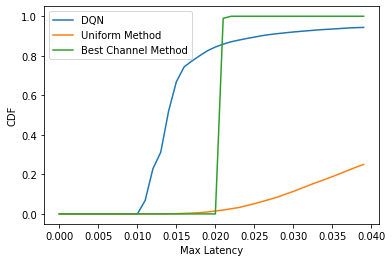

In [ ]:
stats = np.arange(0, 0.04, 0.001)
#stats = np.arange(10, 5000, 10)
#stats = np.arange(2, 250, 2)
dqn_cdf =np.zeros([1,len(stats)])[0]
unif_cdf =np.zeros([1,len(stats)])[0]
const_cdf =np.zeros([1,len(stats)])[0]
#solo1_cdf =np.zeros([1,len(stats)])[0]
#solo2_cdf =np.zeros([1,len(stats)])[0]
count = 0
for il in stats:
  #print('index ' + str(il))
  tata = len(np.argwhere(dqn_ep_reward_list<il))
  #print('count ' + str(tata))
  tata2 = len(np.argwhere(unif_reward_list<il))
  tata3 = len(np.argwhere(const_reward_list<il))
  tata4 = len(np.argwhere(solo1<il))
  tata5 = len(np.argwhere(solo2<il))
  dqn_cdf[count] = tata/((200+ep*200)/num_user) #(1000+ep*1000)  (200+ep*200)
  unif_cdf[count] = tata2/((200+ep*200)/num_user)
  const_cdf[count] = tata3/((200+ep*200)/num_user)
  #solo1_cdf[count] = tata4/((200+ep*200)/2)
  #solo2_cdf[count] = tata4/((200+ep*200)/2)
  count = count + 1


plt.plot(stats,dqn_cdf)
plt.plot(stats,unif_cdf)
plt.plot(stats,const_cdf)
#plt.plot(solo1_cdf)
#plt.plot(solo2_cdf)
plt.xlabel("Max Latency")
plt.ylabel("CDF")
plt.legend(['DQN', 'Uniform Method', 'Best Channel Method'])
plt.show()

In [ ]:
print(8239/((200+ep*200)/num_user))


0.8239


In [ ]:
# Save the weights
model.save_weights("sam260.h5")
#critic_model.save_weights("cell_critic.h5")

#target_actor.save_weights("cell_target_actor.h5")
#target_critic.save_weights("cell_target_critic.h5")

In [ ]:
#getting new channel state info
data222 = files.upload()
for f in data222.keys():
    file = open(f, 'r')
    testlines = file.readlines()
print(testlines)

Saving VER45_10AP_2UE_NO_SHAD_Hmat_scenario3_10APs_Multi_2_users_FUNFINALACTUREG_complex_part2_7_28_ExtendingTesting_ver62.txt to VER45_10AP_2UE_NO_SHAD_Hmat_scenario3_10APs_Multi_2_users_FUNFINALACTUREG_complex_part2_7_28_ExtendingTesting_ver62.txt
['-0.02411 -0.05007 -0.04046 0.01383 0.01534 -0.00577 0.00071 0.00976 0.00495 -0.00328 -0.02206 0.00145 0.00403 -0.01359 -0.00314 -0.00624 -0.00228 -0.00180 -0.00071 0.01108\n', '0.01096 0.00725 -0.00194 -0.01294 -0.01747 -0.02212 -0.00416 -0.00295 0.01351 0.00027 -0.00555 0.00013 -0.00197 -0.00401 0.00083 0.00273 -0.00944 0.00280 0.00880 -0.00888\n', '-0.02191 -0.01665 -0.02011 -0.00633 0.02449 -0.00020 0.02012 0.01217 0.01971 0.00122 0.01008 0.00212 0.00448 -0.00443 0.00008 -0.01349 0.00160 0.00343 -0.00331 -0.00646\n', '0.02418 0.04338 -0.03083 -0.07277 -0.01081 0.02487 -0.00437 0.00631 0.00296 -0.01207 -0.00030 0.00782 0.00224 -0.00074 0.01683 -0.00416 0.00076 -0.00538 -0.00350 -0.00415\n', '0.06485 -0.01705 0.02615 0.01332 0.01249 0.02

In [ ]:
pos = 0
raw_iq = []
complex_vec2 = []
complex_vec_total_p2 = []
count = 0
count2 = 0

for i in range(num_user):
  temp = testlines[pos+i]
  temp = temp.strip()
  temp = temp.split(' ')
  raw_iq.append(temp)
  print(raw_iq[i])

for i in range(num_user):
  for jslack in raw_iq[i]:
  #i = float(i)
    if count % 2 == 0:
      tens = float(raw_iq[i][count])
    if  count % 2 == 1:
      complex_vec2.append(complex(tens,float(raw_iq[i][count])))
      count2 = count2+ 1
    count = count + 1
  complex_vec_total_p2.append(complex_vec2)
  complex_vec2 = []
  count = 0
  count2 = 0

print(complex_vec_total_p2[0])
print(complex_vec_total_p2[1])



['-0.02411', '-0.05007', '-0.04046', '0.01383', '0.01534', '-0.00577', '0.00071', '0.00976', '0.00495', '-0.00328', '-0.02206', '0.00145', '0.00403', '-0.01359', '-0.00314', '-0.00624', '-0.00228', '-0.00180', '-0.00071', '0.01108']
['0.01096', '0.00725', '-0.00194', '-0.01294', '-0.01747', '-0.02212', '-0.00416', '-0.00295', '0.01351', '0.00027', '-0.00555', '0.00013', '-0.00197', '-0.00401', '0.00083', '0.00273', '-0.00944', '0.00280', '0.00880', '-0.00888']
[(-0.02411-0.05007j), (-0.04046+0.01383j), (0.01534-0.00577j), (0.00071+0.00976j), (0.00495-0.00328j), (-0.02206+0.00145j), (0.00403-0.01359j), (-0.00314-0.00624j), (-0.00228-0.0018j), (-0.00071+0.01108j)]
[(0.01096+0.00725j), (-0.00194-0.01294j), (-0.01747-0.02212j), (-0.00416-0.00295j), (0.01351+0.00027j), (-0.00555+0.00013j), (-0.00197-0.00401j), (0.00083+0.00273j), (-0.00944+0.0028j), (0.0088-0.00888j)]


In [ ]:
#load weights -- need to understand what's needed here during testing phase
model.load_weights("sam260.h5")


# To store reward history of each episode
ep_reward_list = []
dqn_ep_reward_list = []
# To store average reward history of last few episodes
const_reward_list = []
unif_reward_list = []
new_reward = 0
best_alphas = np.zeros(shape=(1,num_APs))
#best_alphas = np.zeros(shape=(1,10))
b1  = 0
indexxx = 0
total_episodes = 1
# Takes about 4 min to train
for ep in range(total_episodes):

    #prev_state = env.reset() ep*1000
    prev_state = np.zeros([num_states,])
    prev_state_dqn = prev_state
    episodic_reward = 0
    alphasss = []
    for i in range(num_user):
      rand_vecs = np.random.random(size=(1,num_APs))
      rand_vecs = rand_vecs/np.sum(rand_vecs)
      alphasss.append(rand_vecs[0])
    
    #indexxx = ep*1000
    #print('Step')
    #print(indexxx)
    #print(200+ep*200)
    '''
    comp, fla = converttt(lines,0)
    prev_state[0:10] = fla
    prev_state[10:21] = alphasss
    '''

    #while indexxx < len(testlines)-1:
    while indexxx < len(testlines)-(num_user-1):
        # Uncomment this to see the Actor in action
        # But not in a python notebook.
        # env.render()
        #print(prev_state)
        #prev_state = np.asarray(prev_state).astype(np.float32)  
        #tf_prev_state = [[]]*num_user
        '''
        if indexxx > 0:
          for jwiw in range(num_user):
            tf_prev_state[jwiw] = (tf.expand_dims(tf.convert_to_tensor(prev_state[jwiw],dtype=np.float32), 0))
        else:
          for jwiw in range(num_user):
            tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state[jwiw],dtype=np.float32), 0)

      
        actions = []
        
        if indexxx == 0:
          for ikea in range(num_user):
            actions.append(np.asarray(alphasss[ikea]))
        else:
          for ikea22 in range(num_user):
            actions.append(policy_testing(tf_prev_state[ikea22])[0])
          #action = softmax(tf_prev_state)
          ######action = action[0]
          
          #TO EXPERIMENT COMMENTING THIS OUT

        '''
          
        latencies_co = []
        latencies_u_co = []
        latencies_b_co = []
        sum_temp = np.zeros(shape=(1,num_APs))
        sum_den = np.zeros(shape=(1,num_APs))
        sum_temp_u = np.zeros(shape=(1,num_APs))
        sum_den_u = np.zeros(shape=(1,num_APs))
        sum_temp_b = []
        sum_den_b = []
        '''
        for swag in range(num_user):
          action = actions[swag]
    
          alphasss = action
          ########################product = alphasss*S_u
          oneminussquared = (1-alphasss)**2
          squareddd = alphasss**2
          chan_squared = (np.absolute(complex_vec_total_p2[swag])**2)

          #num = ((B*np.log2(1+((p*ada_1)*(squareddd*chan_squared)))))
          ###########################den = 1+ ((p*ada_1)*(oneminussquared*chan_squared))
          den = ((p*ada_1)*(oneminussquared*chan_squared))





          temp = (((p*ada_1)*(squareddd*chan_squared)))
          ############################rate = ((B*np.log2((1+(((p*ada_1)*(squareddd*chan_squared))/den)))))


          sum_den[0] = sum_den[0] + den
          sum_temp[0] = sum_temp[0] + temp



          # should do this if somehow channel becomes zero (i.e. shadow)
        
        rate = ((B*np.log2((1+((sum_temp)/(1+sum_den))))))


        un_dB_sinr = ((sum_temp)/(1+sum_den))

        #### CHecking ###
        
        for sew in range(num_user):
        
          alphasss_indices = np.where(actions[sew]==0)[0]
          print('Alphas Indices')
          print(alphasss_indices)


          new_rate = rate[0].copy()

          
          for i in alphasss_indices:  #setting rates where alpha = 0 to zero
            new_rate[i] = 0 

          print('Alphasss')
          print(actions[sew])
          new_alphasss = actions[sew][actions[sew] != 0]

          
          observing_rate_indices = np.where(new_rate==0)[0]
          observing_alphasss_indices = np.where(actions[sew]==0)[0]
          tezerk = len(observing_rate_indices)
          tezerk2 = len(observing_alphasss_indices)

          if tezerk != tezerk2:
            print('Size Damn it')
            print('chan squared')
            print(chan_squared)
            print('Alphas')
            print(alphasss)
            print('Temp')
            print(temp)
            print('Den')
            print(den)
            print('Rate')
            print(rate[0])
            print('New Rate')
            print(new_rate)
            quit()

          for excak in range(tezerk):
            if observing_rate_indices[excak] != observing_alphasss_indices[excak]:
              print('Damn it')
              print(chan_squared)
              print('Alphas')
              print(alphasss)
              print('Temp')
              print(temp)
              print('Den')
              print(den)
              print('Rate')
              print(rate[0])
              print('New Rate')
              print(new_rate)
              quit()
          



          ##TODO: FOR THE ALPHAS THAT ARE ZERO REMOVE THE CORRESPONDING INDICES FROM THE RATE EVEN IF NOT ZERO INSTEAD OF SEEING IF THEY MATCH
          new_rate = new_rate[new_rate != 0]
          product = actions[sew]*S_u

          product = product[product!=0]
          

        
      

  

          #un_dB_sinr = (2**(new_rate/B)) - 1


          #un_dB_sinr = ((((p*ada_1)*(squareddd*chan_squared))/den))




      # Recieve state and reward from environment.
      #state, reward, done, info = env.step(action)
          
          total_latency = (beta1*(new_alphasss*S_u*C)/freq) +  (beta2*(product/new_rate))

          latencies_co.append(total_latency)
        


        final_rewards = []
        for fight in range(num_user):
          final_rewards.append(np.max(latencies_co[fight]))

        #xx1 = np.max(latencies_co[0])
        #xx2 = np.max(latencies_co[1])
        #reward =np.mean([xx1, xx2]) 
        #reward = np.max([xx1,xx2])
        reward = np.max(final_rewards)

        
        if indexxx >0 and indexxx < len(testlines):
          ep_reward_list.append(reward)

        #reward =np.sum([xx1, xx2]) 
        '''


        tf_prev_state_dqn = [[]]*num_user
        if indexxx > 0:
          print('Step')
          print(indexxx)
          for jwiw in range(num_user):
            tf_prev_state_dqn[jwiw] = (tf.expand_dims(tf.convert_to_tensor(prev_state_dqn[jwiw],dtype=np.float32), 0))
        else:
          for jwiw in range(num_user):
            tf_prev_state_dqn = tf.expand_dims(tf.convert_to_tensor(prev_state_dqn[jwiw],dtype=np.float32), 0)
           
       

        actions_dqn = []
        if indexxx == ep*200:
            # Take random action
            for ikea in range(num_user):
              actions_dqn.append(np.random.choice(num_actions))
        else:
            # Predict action Q-values
            # From environment state

            #state_tensor = tf.convert_to_tensor(prev_state)
            #state_tensor = tf.expand_dims(state_tensor, 0)
            for ikea in range(num_user):
              action_probs_dqn = model(tf_prev_state_dqn[ikea], training=False)
            # Take best action
              actions_dqn.append(tf.argmax(action_probs_dqn[0]).numpy())


        latencies_co_dqn = []
        sum_temp_dqn = np.zeros(shape=(1,num_APs))
        sum_den_dqn = np.zeros(shape=(1,num_APs))
        actual_actions_dqn = []
        for swag in range(num_user):
          action_dqn = actions_dqn[swag]
    
          alphasss_dqn = np.array(dict_actions[str(action_dqn)],dtype=float)
          actual_actions_dqn.append(alphasss_dqn)
          ########################product = alphasss*S_u
          oneminussquared_dqn = (1-alphasss_dqn)**2
          squareddd_dqn = alphasss_dqn**2
          chan_squared_dqn = (np.absolute(complex_vec_total_p2[swag])**2)

          #num = ((B*np.log2(1+((p*ada_1)*(squareddd*chan_squared)))))
          ###########################den = 1+ ((p*ada_1)*(oneminussquared*chan_squared))
          den_dqn = ((p*ada_1)*(oneminussquared_dqn*chan_squared_dqn))

          temp_dqn = (((p*ada_1)*(squareddd_dqn*chan_squared_dqn)))
          ############################rate = ((B*np.log2((1+(((p*ada_1)*(squareddd*chan_squared))/den)))))


          sum_den_dqn[0] = sum_den_dqn[0] + den_dqn
          sum_temp_dqn[0] = sum_temp_dqn[0] + temp_dqn



          # should do this if somehow channel becomes zero (i.e. shadow)
        
        rate_dqn = ((B*np.log2((1+((sum_temp_dqn)/(1+sum_den_dqn))))))

        dqn_un_dB_sinr = ((sum_temp_dqn)/(1+sum_den_dqn))
        '''
        if indexxx > 0:
          print('Original')
          print(rate)
        '''
        #### CHecking ###
        for sew in range(num_user):
        
          alphasss_indices_dqn = np.where(actual_actions_dqn[sew]==0)[0]
          print('Alphas Indices')
          print(alphasss_indices_dqn)

          new_rate_dqn = rate_dqn[0].copy()

          
          for i in alphasss_indices_dqn:  #setting rates where alpha = 0 to zero
            new_rate_dqn[i] = 0 
 
          print('DQN Alphasss ' )
          print(actions_dqn)
          new_alphasss_dqn = actual_actions_dqn[sew][actual_actions_dqn[sew] != 0]

          
          observing_rate_indices_dqn = np.where(new_rate_dqn==0)[0]
          observing_alphasss_indices_dqn = np.where(actual_actions_dqn[sew]==0)[0]
          tezerk = len(observing_rate_indices_dqn)
          tezerk2 = len(observing_alphasss_indices_dqn)

          if tezerk != tezerk2:
            print('Size Damn it')
            print('chan squared')
            print(chan_squared_dqn)
            print('Alphas')
            print(alphasss_dqn)
            print('Temp')
            print(temp_dqn)
            print('Den')
            print(den_dqn)
            print('Rate')
            print(rate_dqn[0])
            print('New Rate')
            print(new_rate_dqn)
            quit()

          for excak in range(tezerk):
            if observing_rate_indices_dqn[excak] != observing_alphasss_indices_dqn[excak]:
              print('Damn it')
              print(chan_squared_dqn)
              print('Alphas')
              print(alphasss_dqn)
              print('Temp')
              print(temp_dqn)
              print('Den')
              print(den_dqn)
              print('Rate')
              print(rate_dqn[0])
              print('New Rate')
              print(new_rate_dqn)
              quit()
          



          ##TODO: FOR THE ALPHAS THAT ARE ZERO REMOVE THE CORRESPONDING INDICES FROM THE RATE EVEN IF NOT ZERO INSTEAD OF SEEING IF THEY MATCH
          new_rate_dqn = new_rate_dqn[new_rate_dqn != 0]
          product_dqn = actual_actions_dqn[sew]*S_u

          product_dqn = product_dqn[product_dqn!=0]

        
      

  

          #un_dB_sinr = (2**(new_rate/B)) - 1


        ###################################un_dB_sinr = ((((p*ada_1)*(squareddd*chan_squared))/den))




      # Recieve state and reward from environment.
      #state, reward, done, info = env.step(action)
          
          total_latency_dqn = (beta1*(new_alphasss_dqn*S_u*C)/freq) + (beta2*(product_dqn/new_rate_dqn))
          latencies_co_dqn.append(total_latency_dqn)

        
        xx1_dqn = np.max(latencies_co_dqn[0])
        xx2_dqn = np.max(latencies_co_dqn[1])

        reward_dqn = np.max([xx1_dqn, xx2_dqn]) 
        if indexxx >0 and indexxx < len(testlines):
          dqn_ep_reward_list.append(reward_dqn)







      



        # End this episode when `done` is True
        #if done:
        #    break

        #prev_state = state
        #ep_reward_list.append(episodic_reward)
 
        ##### UNIFORM
        ##### UNIFORM
        for delicious in range(num_user):
          unif_alphasss = 1/num_APs*np.ones([1,num_APs]) 
          #unif_alphasss = 1/10*np.ones([1,10]) 
          product_u = unif_alphasss*S_u
          oneminussquared_u = (1-unif_alphasss)**2
          squareddd_u = unif_alphasss**2
          chan_squared_u = (np.absolute(complex_vec_total_p2[delicious])**2)

          #num = ((B*np.log2(1+((p*ada_1)*(squareddd*chan_squared)))))
          ########################den_u = 1+ ((p*ada_1)*(oneminussquared_u*chan_squared_u))
          den_u = ((p*ada_1)*(oneminussquared_u*chan_squared_u))
          temp_u = (((p*ada_1)*(squareddd_u*chan_squared_u)))


          sum_den_u[0] = sum_den_u[0] + den_u
          sum_temp_u[0] = sum_temp_u[0] + temp_u

          #########rate_u = ((B*np.log2((1+(((p*ada_1)*(squareddd_u*chan_squared_u))/den_u)))))

          
        rate_u = ((B*np.log2((1+((sum_temp_u)/(1+sum_den_u))))))   
        total_latency_u = (beta1*(unif_alphasss*S_u*C)/freq) + (beta2*(product_u/rate_u))
        #because alphas are always uniform for both users, can just multiply reward by 2. 
        reward_u = np.max(total_latency_u[0])  
        #reward_u = 2*np.max(total_latency_u[0])  
        '''
        latencies_u_co.append(total_latency_u[0])
        xx1_u = np.max(latencies_u_co[0])
        xx2_u = np.max(latencies_u_co[1])
        reward_u =np.sum([xx1_u, xx2_u]) 
       '''
        
        ##NEW - 7/16
        if indexxx >0 and indexxx < len(testlines):
          unif_reward_list.append(reward_u)


        #### BEST Method
        best_channel_gains = []
        final_best_reward = []
        #### BEST Method
        for great in range(num_user):
          best_id = np.argmax(np.abs(complex_vec_total_p2)[great])
          best_channel_gains.append(best_id)
          best_alphasss = 1

          product_b = best_alphasss*S_u
          oneminussquared_b = (1-best_alphasss)**2
          squareddd_b = best_alphasss**2

          chan_squared_b = (np.absolute(complex_vec_total_p2[great][best_id])**2)

          #num = ((B*np.log2(1+((p*ada_1)*(squareddd*chan_squared)))))
          #####################den_b = 1+ ((p*ada_1)*(oneminussquared_b*chan_squared_b))
          den_b = ((p*ada_1)*(oneminussquared_b*chan_squared_b))
          temp_b = (((p*ada_1)*(squareddd_b*chan_squared_b)))
          sum_den_b.append(den_b)
          sum_temp_b.append(temp_b)
          #####################rate_b = ((B*np.log2((1+(((p*ada_1)*(squareddd_b*chan_squared_b))/den_b)))))
         
        duplicates = []
        for j in best_channel_gains:
          if j in duplicates:
            continue
          else:
            timeagain = np.argwhere(best_channel_gains == j)[0]
            #if more than 1 sum up the indices
            temp_sum_den_b = 0
            temp_sum_temp_b = 0
          for iterating in timeagain:
            temp_sum_den_b = temp_sum_den_b + sum_den_b[iterating]
            temp_sum_temp_b = temp_sum_temp_b + sum_temp_b[iterating]
          
          rate_b = ((B*np.log2((1+((temp_sum_temp_b)/(1+temp_sum_den_b))))))
          total_latency_b = (beta1*(best_alphasss*S_u*C)/freq) + (beta2*(product_b/rate_b))
          latencies_b_co.append(total_latency_b)
          #delete from best_gains
          duplicates.append(timeagain[0])


        '''


        if best_channel_gains[0] == best_channel_gains[1]: # if same AP is chosen for both add them together. 
          sum_den_bb = np.sum(sum_den_b)
          sum_temp_bb = np.sum(sum_temp_b) #need to add for same alpha
          rate_b = ((B*np.log2((1+((sum_temp_bb)/(1+sum_den_bb))))))
          total_latency_b = (beta1*(best_alphasss*S_u*C)/freq) + (beta2*(product_b/rate_b))
          reward_b = total_latency_b #because same alpha
        else:  # if not they are sepearte entities
          for i in range(len(sum_den_b)):
            rate_b = ((B*np.log2((1+((sum_temp_b[i])/(1+sum_den_b[i]))))))
            total_latency_b = (beta1*(best_alphasss*S_u*C)/freq) + (beta2*(product_b/rate_b))
            latencies_b_co.append(total_latency_b)
          
          xx1_b = np.max(latencies_b_co[0])
          xx2_b = np.max(latencies_b_co[1])
          #reward_b =np.mean([xx1_b, xx2_b]) 
          reward_b =np.max([xx1_b, xx2_b]) 
          #reward_b =np.sum([xx1_b, xx2_b]) 
        '''

        reward_b = np.max(latencies_b_co)

      
       
         #NEW - 7/16
        if indexxx > 0 and indexxx < len(testlines):
          const_reward_list.append(reward_b)

        print('Step')
        print(indexxx)
        indexxx = indexxx + num_user #2#1
        '''
        if indexxx < len(testlines):
          complex_vec_total_p2 = converttt(testlines,indexxx)
          state = []
          for iii in range(num_user):
            status =  np.empty((1, num_states), dtype=np.object)  #TODO: how to assign to None,30 or convert 1,1,30 to None,3
            for jwe in range(num_states):
              #status[0][jwe] = np.log2(np.absolute(complex_vec_total_p2[iii][jwe])) #un_dB_sinr[0][jwe]
              status[0][jwe] = (un_dB_sinr[0][jwe])
            
            status= status[0].astype('float64')
              #############state[0][iii] = (un_dB_sinr[0][iii])
            state.append(status)
            
           
          
          #state = state[0].astype('float64')
        else:
          print('Stop')
          break
        
        
        '''




        
        #print('Computational latency')
        #print((beta1*(new_alphasss*S_u*C)/freq)) 
        #print('Transmission Latency')
        #print(beta2*(product/new_rate))
        print('Reward')
        print(reward_dqn)


        state_next_dqn = []
        if indexxx < len(testlines):
          #complex_vec,float_line = converttt(lines,indexxx)
          complex_vec_total_p2 = converttt(testlines,indexxx)
          for iii in range(num_user):
            tank =  np.empty((1, num_states), dtype=np.object)
            tank = (dqn_un_dB_sinr) #TODO: PRINT UN_DB_SINR

            #state_next, reward, done, _ = env.step(action)
            #######state_next_dqn = np.array(tank)
            state_next_dqn.append(np.array(tank))
        
        else:
          print('Stop')
          break
        prev_state_dqn = state_next_dqn

        

        ############buffer.record((prev_state, alphasss, reward, state)) #dont know if this should be -reward or not
          
        #episodic_reward = (reward)
        
        #indexxx = indexxx + 1
        #prev_state = state

        #ep_reward_list.append(episodic_reward)

        

    #ep_reward_list.append(episodic_reward)
    

    ## Mean of last 40 episodes
    ##avg_reward = np.mean(ep_reward_list[-40:])
    #print("Episode * {} * Avg Reward is ==> {}".format(ep, avg_reward))
    #vg_reward_list.append(avg_reward)

# Plotting graph
# Episodes versus Avg. Rewards
print(indexxx)
#count = b1/float(1000)
#print(count)

Alphas Indices
[0 1 4 5 6 7 8 9]
DQN Alphasss 
[0, 5]
Alphas Indices
[0 2 3 4 5 6 7 8]
DQN Alphasss 
[0, 5]
Step
0
Reward
0.019354844562030404
['-0.02191', '-0.01665', '-0.02011', '-0.00633', '0.02449', '-0.00020', '0.02012', '0.01217', '0.01971', '0.00122', '0.01008', '0.00212', '0.00448', '-0.00443', '0.00008', '-0.01349', '0.00160', '0.00343', '-0.00331', '-0.00646']
['0.02418', '0.04338', '-0.03083', '-0.07277', '-0.01081', '0.02487', '-0.00437', '0.00631', '0.00296', '-0.01207', '-0.00030', '0.00782', '0.00224', '-0.00074', '0.01683', '-0.00416', '0.00076', '-0.00538', '-0.00350', '-0.00415']
Step
2
Alphas Indices
[0 1 4 5 6 7 8 9]
DQN Alphasss 
[0, 0]
Alphas Indices
[0 1 4 5 6 7 8 9]
DQN Alphasss 
[0, 0]
Step
2
Reward
0.010999712427997497
['0.06485', '-0.01705', '0.02615', '0.01332', '0.01249', '0.02037', '-0.00195', '0.00093', '0.01112', '0.01662', '-0.00463', '0.00379', '0.00673', '0.01140', '-0.00744', '0.00443', '-0.01263', '0.00618', '-0.00276', '-0.00536']
['0.01061', '-0.0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:552: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Streaming output truncated to the last 5000 lines.
DQN Alphasss 
[0, 0]
Step
1374
Reward
0.011208403129558715
['0.02243', '-0.03689', '0.00948', '0.00659', '-0.01003', '-0.00853', '0.03154', '0.02744', '-0.01818', '0.00514', '-0.01269', '-0.00765', '0.01048', '0.00296', '0.00411', '0.00866', '-0.00794', '0.01899', '0.00573', '-0.01164']
['0.05783', '0.01488', '-0.01154', '-0.03963', '0.00228', '0.03243', '0.00007', '-0.00998', '-0.00793', '0.01033', '-0.00366', '-0.00040', '0.00197', '0.01188', '-0.00477', '-0.00238', '-0.00139', '0.00793', '0.01169', '-0.02293']
Step
1376
Alphas Indices
[0 1 4 5 6 7 8 9]
DQN Alphasss 
[0, 0]
Alphas Indices
[0 1 4 5 6 7 8 9]
DQN Alphasss 
[0, 0]
Step
1376
Reward
0.011041956219947007
['-0.03616', '0.01190', '-0.00995', '0.02081', '-0.00574', '0.04126', '0.01339', '-0.00912', '-0.01061', '0.00493', '-0.01378', '0.01239', '0.00777', '0.01242', '-0.00263', '0.00972', '0.00267', '-0.00683', '-0.00331', '-0.00618']
['0.03182', '0.04844', '-0.00220', '-0.0078

In [ ]:
print(np.shape(state_next_sample))
#print(np.max(ep_reward_list))
#print(np.max(unif_reward_list))
#print(np.max(const_reward_list))

(32, 1, 10)


In [ ]:
print(unif_reward_list)
print(np.max(unif_reward_list))
print(np.max(ep_reward_list))

[162.29996129553876, 198.64842380903443, 199.620965245459, 78.69973051507131, 131.35682167839815, 347.76879231401466, 107.21688667578051, 112.4667322428572, 125.7066255539824, 132.07492943876713, 142.6920650302314, 103.18317372641944, 134.47749863219138, 175.9446947982965, 130.54675107711785, 198.63544560717685, 116.2881675508301, 82.72238247826799, 327.98226601780004, 149.5624886323165, 118.72175020578555, 184.45168587310351, 98.78874937863878, 109.40860442666761, 97.44455018827688, 112.48501033004446, 107.30911362302308, 130.92776014138136, 111.8426209778503, 113.59111663062941, 164.83428025192535, 172.57937068440958, 229.3212342184181, 315.8997473522207, 343.2545604180865, 121.01916792346759, 160.63718213298878, 132.3979098119865, 179.75165474176174, 446.28189850071146, 134.23459204898592, 262.38762903279735, 104.34293542702916, 156.1027318599069, 112.71205762965216, 103.51946105512107, 221.30309331948584, 190.99857985739035, 90.34802586181559, 104.27177304943214, 126.25765860043582

In [ ]:
####################################################

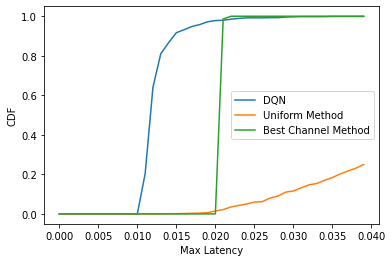

In [ ]:
stats22 = np.arange(0, 0.04, 0.001)
#stats22 = np.arange(5, 300, 5) #400
dqn_cdf22 =np.zeros([1,len(stats22)])[0]
unif_cdf22 =np.zeros([1,len(stats22)])[0]
const_cdf22 =np.zeros([1,len(stats22)])[0]
count22 = 0
for il in stats22:
  tata22 = len(np.argwhere(dqn_ep_reward_list<=il))
  tata222 = len(np.argwhere(unif_reward_list<=il))
  tata223 = len(np.argwhere(const_reward_list<=il))
  dqn_cdf22[count22] = tata22/len(dqn_ep_reward_list)#999#1000
  unif_cdf22[count22] = tata222/len(unif_reward_list)#999#1000
  const_cdf22[count22] = tata223/len(const_reward_list)#999#1000
  count22 = count22 + 1

#plt.xlim(0, 70)
plt.plot(stats22,dqn_cdf22)
plt.plot(stats22,unif_cdf22)
plt.plot(stats22,const_cdf22)
plt.xlabel("Max Latency")
plt.ylabel("CDF")
plt.legend(['DQN', 'Uniform Method', 'Best Channel Method'])
plt.show()

In [ ]:
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.2032032
 0.64064064 0.80980981 0.86586587 0.91691692 0.93193193 0.94794795
 0.95795796 0.97197197 0.97797798 0.97997998 0.98498498 0.98898899
 0.99199199 0.99199199 0.99199199 0.99299299 0.99299299 0.995996
 0.996997   0.997998   0.997998   0.997998   0.997998   0.998999
 0.998999   0.998999   0.998999   0.998999  ]


In [ ]:
print(epsilon_greedy_frames)

1000


In [ ]:
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.2002002
 0.63363363 0.8008008  0.85685686 0.91491491 0.93193193 0.94794795
 0.95795796 0.97197197 0.97797798 0.97997998 0.98498498 0.98898899
 0.99199199 0.99199199 0.99199199 0.99299299 0.99299299 0.995996
 0.996997   0.997998   0.997998   0.997998   0.997998   0.998999
 0.998999   0.998999   0.998999   0.998999  ]


In [ ]:
print(dqn_cdf22)  #<=

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.2022022
 0.63863864 0.80780781 0.86386386 0.91591592 0.93193193 0.94794795
 0.95795796 0.97197197 0.97797798 0.97997998 0.98498498 0.98898899
 0.99199199 0.99199199 0.99199199 0.99299299 0.99299299 0.995996
 0.996997   0.997998   0.997998   0.997998   0.997998   0.998999
 0.998999   0.998999   0.998999   0.998999  ]


In [ ]:
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.2022022
 0.63863864 0.80780781 0.86386386 0.91591592 0.93193193 0.94794795
 0.95795796 0.97197197 0.97797798 0.97997998 0.98498498 0.98898899
 0.99199199 0.99199199 0.99199199 0.99299299 0.99299299 0.995996
 0.996997   0.997998   0.997998   0.997998   0.997998   0.998999
 0.998999   0.998999   0.998999   0.998999  ]


In [ ]:
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.2022022
 0.63863864 0.80780781 0.86386386 0.91591592 0.93193193 0.94794795
 0.95795796 0.97197197 0.97797798 0.97997998 0.98498498 0.98898899
 0.99199199 0.99199199 0.99199199 0.99299299 0.99299299 0.995996
 0.996997   0.997998   0.997998   0.997998   0.997998   0.998999
 0.998999   0.998999   0.998999   0.998999  ]


In [ ]:
print(epsilon_greedy_frames)

10000


In [ ]:
print(dict_actions)

{'0': [0.0, 0.0, 0.52401754, 0.47598246, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '1': [0.0, 0.73175478, 0.26824522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '2': [0.0, 0.17128827, 0.0, 0.0, 0.0, 0.0, 0.82871173, 0.0, 0.0, 0.0], '3': [0.67593495, 0.0, 0.32406505, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '4': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46805536, 0.0, 0.0, 0.53194464], '5': [0.0, 0.82117362, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17882638], '6': [0.0, 0.0, 0.0, 0.0, 0.0, 0.48705381, 0.51294619, 0.0, 0.0, 0.0], '7': [0.0, 0.0, 0.0, 0.0, 0.48747732, 0.51252268, 0.0, 0.0, 0.0, 0.0], '8': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.45405668, 0.0, 0.54594332, 0.0], '9': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4212056, 0.0, 0.5787944, 0.0]}


In [ ]:
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.2022022
 0.63863864 0.80780781 0.86386386 0.91591592 0.93193193 0.94794795
 0.95795796 0.97197197 0.97797798 0.97997998 0.98498498 0.98898899
 0.99199199 0.99199199 0.99199199 0.99299299 0.99299299 0.995996
 0.996997   0.997998   0.997998   0.997998   0.997998   0.998999
 0.998999   0.998999   0.998999   0.998999  ]


In [ ]:
print(epsilon_greedy_frames)

10000


In [ ]:
print(dict_actions)

{'0': [0.0, 0.0, 0.52401754, 0.47598246, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '1': [0.0, 0.73175478, 0.26824522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '2': [0.0, 0.17128827, 0.0, 0.0, 0.0, 0.0, 0.82871173, 0.0, 0.0, 0.0], '3': [0.67593495, 0.0, 0.32406505, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '4': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46805536, 0.0, 0.0, 0.53194464], '5': [0.0, 0.82117362, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17882638], '6': [0.0, 0.0, 0.0, 0.0, 0.0, 0.48705381, 0.51294619, 0.0, 0.0, 0.0], '7': [0.0, 0.0, 0.0, 0.0, 0.48747732, 0.51252268, 0.0, 0.0, 0.0, 0.0], '8': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.45405668, 0.0, 0.54594332, 0.0], '9': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4212056, 0.0, 0.5787944, 0.0]}


In [ ]:
##################################

In [ ]:
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.001001
 0.002002   0.00700701 0.01101101 0.01701702 0.02502503 0.03303303
 0.04604605 0.06106106 0.07207207 0.08308308 0.09209209 0.10710711
 0.12312312 0.14614615 0.16316316 0.18118118 0.20520521 0.22822823
 0.23423423 0.24624625 0.26626627 0.28328328 0.3023023  0.31031031
 0.32832833 0.34734735 0.35735736 0.36936937]


In [ ]:
print(epsilon_greedy_frames)

100000


In [ ]:
print(dict_actions)

{'0': [0.0, 0.19074129, 0.23633142, 0.2256996, 0.20456269, 0.0, 0.142665, 0.0, 0.0, 0.0], '1': [0.0, 0.27189425, 0.0, 0.17030932, 0.21046934, 0.26938872, 0.0, 0.0, 0.07793836, 0.0], '2': [0.10275102, 0.30264126, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22669452, 0.25906022, 0.10885299], '3': [0.16654872, 0.32358239, 0.0, 0.03368735, 0.08192548, 0.0, 0.0, 0.0, 0.39425605, 0.0], '4': [0.0, 0.0, 0.31711721, 0.19388919, 0.0, 0.34970154, 0.0, 0.0, 0.13587448, 0.00341758], '5': [0.0, 0.0, 0.17191809, 0.0, 0.25712362, 0.23524776, 0.0, 0.0499325, 0.28577802, 0.0], '6': [0.24856655, 0.27759128, 0.0, 0.14852409, 0.3071876, 0.01813048, 0.0, 0.0, 0.0, 0.0], '7': [0.2183542, 0.0, 0.0, 0.25829537, 0.1073336, 0.0, 0.2033568, 0.21266003, 0.0, 0.0], '8': [0.0, 0.0, 0.22402612, 0.14459276, 0.26519119, 0.23269341, 0.0, 0.13349653, 0.0, 0.0], '9': [0.17358963, 0.0, 0.0, 0.22797795, 0.0, 0.26112856, 0.05295353, 0.0, 0.28435033, 0.0]}


In [ ]:
##############################################

In [ ]:
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.00500501 0.01401401 0.02202202
 0.05205205 0.09009009 0.12812813 0.16416416 0.20720721 0.25025025
 0.3033033  0.34034034 0.37737738 0.41241241 0.44644645 0.48048048
 0.50650651 0.52652653 0.54554555 0.57157157 0.6016016  0.62262262
 0.64064064 0.66466466 0.68268268 0.69369369 0.7037037  0.71671672
 0.73073073 0.74374374 0.75675676 0.76576577]


In [ ]:
print(epsilon_greedy_frames)

1000


In [ ]:
print(dict_actions)

{'0': [0.0, 0.19074129, 0.23633142, 0.2256996, 0.20456269, 0.0, 0.142665, 0.0, 0.0, 0.0], '1': [0.0, 0.27189425, 0.0, 0.17030932, 0.21046934, 0.26938872, 0.0, 0.0, 0.07793836, 0.0], '2': [0.10275102, 0.30264126, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22669452, 0.25906022, 0.10885299], '3': [0.16654872, 0.32358239, 0.0, 0.03368735, 0.08192548, 0.0, 0.0, 0.0, 0.39425605, 0.0], '4': [0.0, 0.0, 0.31711721, 0.19388919, 0.0, 0.34970154, 0.0, 0.0, 0.13587448, 0.00341758], '5': [0.0, 0.0, 0.17191809, 0.0, 0.25712362, 0.23524776, 0.0, 0.0499325, 0.28577802, 0.0], '6': [0.24856655, 0.27759128, 0.0, 0.14852409, 0.3071876, 0.01813048, 0.0, 0.0, 0.0, 0.0], '7': [0.2183542, 0.0, 0.0, 0.25829537, 0.1073336, 0.0, 0.2033568, 0.21266003, 0.0, 0.0], '8': [0.0, 0.0, 0.22402612, 0.14459276, 0.26519119, 0.23269341, 0.0, 0.13349653, 0.0, 0.0], '9': [0.17358963, 0.0, 0.0, 0.22797795, 0.0, 0.26112856, 0.05295353, 0.0, 0.28435033, 0.0]}


In [ ]:
print(const_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.98598599 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.        ]


In [ ]:
print(epsilon_greedy_frames)

100000


In [ ]:
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.001001
 0.002002   0.00700701 0.01101101 0.01701702 0.02502503 0.03303303
 0.04604605 0.06106106 0.07207207 0.08308308 0.09209209 0.10710711
 0.12312312 0.14614615 0.16316316 0.18118118 0.20520521 0.22822823
 0.23423423 0.24624625 0.26626627 0.28328328 0.3023023  0.31031031
 0.32832833 0.34734735 0.35735736 0.36936937]


In [ ]:
print(dict_actions)

{'0': [0.0, 0.19074129, 0.23633142, 0.2256996, 0.20456269, 0.0, 0.142665, 0.0, 0.0, 0.0], '1': [0.0, 0.27189425, 0.0, 0.17030932, 0.21046934, 0.26938872, 0.0, 0.0, 0.07793836, 0.0], '2': [0.10275102, 0.30264126, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22669452, 0.25906022, 0.10885299], '3': [0.16654872, 0.32358239, 0.0, 0.03368735, 0.08192548, 0.0, 0.0, 0.0, 0.39425605, 0.0], '4': [0.0, 0.0, 0.31711721, 0.19388919, 0.0, 0.34970154, 0.0, 0.0, 0.13587448, 0.00341758], '5': [0.0, 0.0, 0.17191809, 0.0, 0.25712362, 0.23524776, 0.0, 0.0499325, 0.28577802, 0.0], '6': [0.24856655, 0.27759128, 0.0, 0.14852409, 0.3071876, 0.01813048, 0.0, 0.0, 0.0, 0.0], '7': [0.2183542, 0.0, 0.0, 0.25829537, 0.1073336, 0.0, 0.2033568, 0.21266003, 0.0, 0.0], '8': [0.0, 0.0, 0.22402612, 0.14459276, 0.26519119, 0.23269341, 0.0, 0.13349653, 0.0, 0.0], '9': [0.17358963, 0.0, 0.0, 0.22797795, 0.0, 0.26112856, 0.05295353, 0.0, 0.28435033, 0.0]}


In [ ]:
print(epsilon_greedy_frames)

100000


In [ ]:
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.3003003  0.5965966  0.70670671
 0.78678679 0.84084084 0.87587588 0.8978979  0.91591592 0.92492492
 0.93793794 0.94494494 0.94794795 0.95395395 0.95795796 0.95895896
 0.96596597 0.96796797 0.97097097 0.97497497 0.97897898 0.97897898
 0.97897898 0.97997998 0.98098098 0.98298298 0.98298298 0.98498498
 0.98698699 0.98798799 0.98898899 0.98898899 0.98898899 0.99099099
 0.99199199 0.99199199 0.99199199 0.99199199 0.99199199 0.99199199
 0.99199199 0.99199199 0.99199199 0.99199199 0.99199199 0.99199199
 0.99199199 0.99199199 0.99199199 0.99199199 0.99299299]


In [ ]:
print(epsilon_greedy_frames)

1000


In [ ]:
print(dict_actions)

{'0': [0.0, 0.19074129, 0.23633142, 0.2256996, 0.20456269, 0.0, 0.142665, 0.0, 0.0, 0.0], '1': [0.0, 0.27189425, 0.0, 0.17030932, 0.21046934, 0.26938872, 0.0, 0.0, 0.07793836, 0.0], '2': [0.10275102, 0.30264126, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22669452, 0.25906022, 0.10885299], '3': [0.16654872, 0.32358239, 0.0, 0.03368735, 0.08192548, 0.0, 0.0, 0.0, 0.39425605, 0.0], '4': [0.0, 0.0, 0.31711721, 0.19388919, 0.0, 0.34970154, 0.0, 0.0, 0.13587448, 0.00341758], '5': [0.0, 0.0, 0.17191809, 0.0, 0.25712362, 0.23524776, 0.0, 0.0499325, 0.28577802, 0.0], '6': [0.24856655, 0.27759128, 0.0, 0.14852409, 0.3071876, 0.01813048, 0.0, 0.0, 0.0, 0.0], '7': [0.2183542, 0.0, 0.0, 0.25829537, 0.1073336, 0.0, 0.2033568, 0.21266003, 0.0, 0.0], '8': [0.0, 0.0, 0.22402612, 0.14459276, 0.26519119, 0.23269341, 0.0, 0.13349653, 0.0, 0.0], '9': [0.17358963, 0.0, 0.0, 0.22797795, 0.0, 0.26112856, 0.05295353, 0.0, 0.28435033, 0.0]}


In [ ]:
print(dict_actions)

{'0': [0.0, 0.19074129, 0.23633142, 0.2256996, 0.20456269, 0.0, 0.142665, 0.0, 0.0, 0.0], '1': [0.0, 0.27189425, 0.0, 0.17030932, 0.21046934, 0.26938872, 0.0, 0.0, 0.07793836, 0.0], '2': [0.10275102, 0.30264126, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22669452, 0.25906022, 0.10885299], '3': [0.16654872, 0.32358239, 0.0, 0.03368735, 0.08192548, 0.0, 0.0, 0.0, 0.39425605, 0.0], '4': [0.0, 0.0, 0.31711721, 0.19388919, 0.0, 0.34970154, 0.0, 0.0, 0.13587448, 0.00341758], '5': [0.0, 0.0, 0.17191809, 0.0, 0.25712362, 0.23524776, 0.0, 0.0499325, 0.28577802, 0.0], '6': [0.24856655, 0.27759128, 0.0, 0.14852409, 0.3071876, 0.01813048, 0.0, 0.0, 0.0, 0.0], '7': [0.2183542, 0.0, 0.0, 0.25829537, 0.1073336, 0.0, 0.2033568, 0.21266003, 0.0, 0.0], '8': [0.0, 0.0, 0.22402612, 0.14459276, 0.26519119, 0.23269341, 0.0, 0.13349653, 0.0, 0.0], '9': [0.17358963, 0.0, 0.0, 0.22797795, 0.0, 0.26112856, 0.05295353, 0.0, 0.28435033, 0.0]}


In [ ]:
#random amounts for 5 connections to 10 APs with shadow fading
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.19019019 0.33633634 0.44244244
 0.51851852 0.57557558 0.62962963 0.66266266 0.68668669 0.70970971
 0.73673674 0.75775776 0.77477477 0.78278278 0.79179179 0.80880881
 0.82382382 0.83583584 0.84684685 0.84884885 0.85585586 0.86586587
 0.86986987 0.87487487 0.88188188 0.88288288 0.89089089 0.89289289
 0.8968969  0.9029029  0.90690691 0.91091091 0.91491491 0.91791792
 0.91891892 0.92092092 0.92492492 0.92692693 0.92892893 0.92992993
 0.93193193 0.93293293 0.93393393 0.93693694 0.93893894 0.93993994
 0.94094094 0.94094094 0.94494494 0.94594595 0.94594595]


In [ ]:
#random amounts for 4 connections to 10 APs with sahdow fading
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.11711712 0.42342342 0.53353353 0.61661662 0.66666667 0.7007007
 0.73673674 0.75975976 0.78278278 0.8018018  0.81981982 0.83183183
 0.84584585 0.85185185 0.85985986 0.86886887 0.87487487 0.88188188
 0.88788789 0.89289289 0.8988989  0.9009009  0.9049049  0.90790791
 0.91191191 0.91891892 0.92092092 0.92392392 0.92592593 0.92692693
 0.93193193 0.93493493 0.93693694 0.93893894 0.93893894 0.94094094
 0.94294294 0.94294294 0.94494494 0.94594595 0.94894895 0.94994995
 0.94994995 0.95195195 0.95295295 0.95395395 0.95795796]


In [ ]:
dqn_4_random = [0.    ,     0. ,        0.   ,      0.  ,       0.,         0.,
 0.    ,     0.       ,  0.      ,   0.       ,  0.       ,  0.,
 0.11711712, 0.42342342, 0.53353353, 0.61661662, 0.66666667, 0.7007007,
 0.73673674, 0.75975976, 0.78278278, 0.8018018 , 0.81981982, 0.83183183,
 0.84584585, 0.85185185, 0.85985986, 0.86886887, 0.87487487, 0.88188188,
 0.88788789, 0.89289289, 0.8988989 , 0.9009009 , 0.9049049 , 0.90790791,
 0.91191191, 0.91891892, 0.92092092, 0.92392392, 0.92592593, 0.92692693,
 0.93193193, 0.93493493, 0.93693694, 0.93893894, 0.93893894, 0.94094094,
 0.94294294, 0.94294294, 0.94494494, 0.94594595, 0.94894895, 0.94994995,
 0.94994995, 0.95195195, 0.95295295, 0.95395395, 0.95795796]

In [ ]:
#random aounts for 3 connections to 10 APs with shadow fading
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.51251251 0.65065065 0.72272272
 0.78078078 0.81181181 0.84184184 0.85885886 0.87887888 0.89289289
 0.90690691 0.91491491 0.92192192 0.92592593 0.92892893 0.93393393
 0.93793794 0.94394394 0.94694695 0.95095095 0.95495495 0.95895896
 0.96096096 0.96396396 0.96696697 0.96896897 0.96996997 0.97097097
 0.97097097 0.97097097 0.97297297 0.97497497 0.97697698 0.97897898
 0.98398398 0.98398398 0.98498498 0.98598599 0.98598599 0.98698699
 0.98698699 0.98698699 0.98698699 0.98698699 0.98698699]


In [ ]:
dqn_3_random = [0.    ,     0.   ,      0.    ,     0.   ,      0.  ,       0.,
 0.     ,    0.        , 0.       ,  0.        , 0.       ,  0.,
 0.      ,   0.        , 0.       ,  0.51251251, 0.65065065, 0.72272272,
 0.78078078, 0.81181181, 0.84184184, 0.85885886, 0.87887888, 0.89289289,
 0.90690691, 0.91491491, 0.92192192, 0.92592593, 0.92892893, 0.93393393,
 0.93793794, 0.94394394, 0.94694695, 0.95095095, 0.95495495, 0.95895896,
 0.96096096, 0.96396396, 0.96696697, 0.96896897, 0.96996997, 0.97097097,
 0.97097097, 0.97097097, 0.97297297, 0.97497497, 0.97697698, 0.97897898,
 0.98398398, 0.98398398, 0.98498498, 0.98598599, 0.98598599, 0.98698699,
 0.98698699, 0.98698699, 0.98698699, 0.98698699, 0.98698699]

In [ ]:
#random aounts for 2 connections to 10 APs with shadow fading
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.66366366 0.82282282 0.89189189 0.91791792
 0.93293293 0.94594595 0.95395395 0.96296296 0.96696697 0.96896897
 0.97097097 0.97697698 0.97897898 0.98198198 0.98398398 0.98598599
 0.98598599 0.98698699 0.98698699 0.98798799 0.98798799 0.98798799
 0.98798799 0.98898899 0.98998999 0.99399399 0.99399399 0.99399399
 0.99399399 0.99399399 0.99399399 0.99399399 0.99399399 0.99499499
 0.99499499 0.99499499 0.995996   0.996997   0.996997  ]


In [ ]:
dqn_2_random = [0.    ,     0.    ,     0.    ,     0.,         0.     ,    0.,
 0.    ,     0.        , 0.        , 0.        , 0.     ,    0.,
 0.     ,    0.        , 0.        , 0.        , 0.      ,   0.,
 0.      ,   0.        , 0.66366366, 0.82282282, 0.89189189, 0.91791792,
 0.93293293, 0.94594595, 0.95395395, 0.96296296, 0.96696697, 0.96896897,
 0.97097097, 0.97697698, 0.97897898, 0.98198198, 0.98398398, 0.98598599,
 0.98598599, 0.98698699, 0.98698699, 0.98798799, 0.98798799, 0.98798799,
 0.98798799, 0.98898899, 0.98998999, 0.99399399, 0.99399399, 0.99399399,
 0.99399399, 0.99399399, 0.99399399, 0.99399399, 0.99399399, 0.99499499,
 0.99499499, 0.99499499, 0.995996  , 0.996997 ,  0.996997  ]

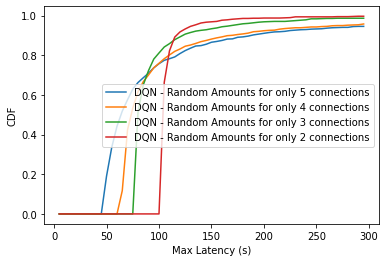

In [ ]:
plt.plot(stats22,dqn_cdf22)
plt.plot(stats22,dqn_4_random)
plt.plot(stats22,dqn_3_random)
plt.plot(stats22,dqn_2_random)
plt.xlabel("Max Latency (s)")
plt.ylabel("CDF")
plt.legend(['DQN - Random Amounts for only 5 connections','DQN - Random Amounts for only 4 connections','DQN - Random Amounts for only 3 connections', 'DQN - Random Amounts for only 2 connections'])
plt.show()

In [ ]:
print(epsilon_greedy_frames)

1000


In [ ]:
############################################### 9_19

In [ ]:
#random aounts for connect to 5 for 10 APs - without shadow fading
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.92892893 0.95295295 0.97197197 0.97997998 0.98698699 0.99099099
 0.995996   0.996997   0.997998   0.997998   0.998999   0.998999
 0.998999   0.998999   1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]


In [ ]:
#Random amounts for connect to 5 for 10 APs - with shaodw fading
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.06906907 0.37337337
 0.49049049 0.57257257 0.62862863 0.67767768 0.70670671 0.72672673
 0.75675676 0.76976977 0.78278278 0.7957958  0.81281281 0.82682683
 0.83683684 0.84684685 0.85385385 0.85985986 0.86586587 0.87587588
 0.87787788 0.88188188 0.88788789 0.89489489 0.8988989  0.9029029
 0.9049049  0.90990991 0.91391391 0.91691692 0.92192192 0.92292292
 0.92392392 0.92792793 0.93193193 0.93193193 0.93393393 0.93593594
 0.93593594 0.93693694 0.94094094 0.94194194 0.94394394 0.94494494
 0.94694695 0.94894895 0.95095095 0.95395395 0.95395395]


In [ ]:
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.06906907 0.37337337
 0.49049049 0.57257257 0.62862863 0.67767768 0.70670671 0.72672673
 0.75675676 0.76976977 0.78278278 0.7957958  0.81281281 0.82682683
 0.83683684 0.84684685 0.85385385 0.85985986 0.86586587 0.87587588
 0.87787788 0.88188188 0.88788789 0.89489489 0.8988989  0.9029029
 0.9049049  0.90990991 0.91391391 0.91691692 0.92192192 0.92292292
 0.92392392 0.92792793 0.93193193 0.93193193 0.93393393 0.93593594
 0.93593594 0.93693694 0.94094094 0.94194194 0.94394394 0.94494494
 0.94694695 0.94894895 0.95095095 0.95395395 0.95395395]


In [ ]:
print(dict_actions)

{'0': [0.0, 0.19074129, 0.23633142, 0.2256996, 0.20456269, 0.0, 0.142665, 0.0, 0.0, 0.0], '1': [0.0, 0.27189425, 0.0, 0.17030932, 0.21046934, 0.26938872, 0.0, 0.0, 0.07793836, 0.0], '2': [0.10275102, 0.30264126, 0.0, 0.0, 0.0, 0.0, 0.0, 0.22669452, 0.25906022, 0.10885299], '3': [0.16654872, 0.32358239, 0.0, 0.03368735, 0.08192548, 0.0, 0.0, 0.0, 0.39425605, 0.0], '4': [0.0, 0.0, 0.31711721, 0.19388919, 0.0, 0.34970154, 0.0, 0.0, 0.13587448, 0.00341758], '5': [0.0, 0.0, 0.17191809, 0.0, 0.25712362, 0.23524776, 0.0, 0.0499325, 0.28577802, 0.0], '6': [0.24856655, 0.27759128, 0.0, 0.14852409, 0.3071876, 0.01813048, 0.0, 0.0, 0.0, 0.0], '7': [0.2183542, 0.0, 0.0, 0.25829537, 0.1073336, 0.0, 0.2033568, 0.21266003, 0.0, 0.0], '8': [0.0, 0.0, 0.22402612, 0.14459276, 0.26519119, 0.23269341, 0.0, 0.13349653, 0.0, 0.0], '9': [0.17358963, 0.0, 0.0, 0.22797795, 0.0, 0.26112856, 0.05295353, 0.0, 0.28435033, 0.0]}


In [ ]:
#Random amounts for connect to 4 for 10 APs - with sahdow fading
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.10710711 0.51751752 0.61461461
 0.67667668 0.71771772 0.74074074 0.76176176 0.77377377 0.79079079
 0.8038038  0.80980981 0.81481481 0.81881882 0.82582583 0.83183183
 0.84484484 0.84984985 0.85485485 0.85885886 0.86586587 0.87387387
 0.87787788 0.88388388 0.89189189 0.89389389 0.9019019  0.90690691
 0.91091091 0.91291291 0.91291291 0.91691692 0.91691692 0.91891892
 0.91991992 0.92092092 0.92092092 0.92792793 0.93093093 0.93093093
 0.93293293 0.93493493 0.93593594 0.93793794 0.93893894]


In [ ]:
dqn_cdf_4_conn = [0.     ,    0. ,        0.   ,      0.      ,   0.,         0.,
 0. ,   0.       ,  0.   ,      0.        , 0.  ,       0.,
 0.       ,  0.       ,  0.    ,     0.10710711, 0.51751752, 0.61461461,
 0.67667668, 0.71771772, 0.74074074, 0.76176176, 0.77377377, 0.79079079,
 0.8038038 , 0.80980981, 0.81481481, 0.81881882, 0.82582583, 0.83183183,
 0.84484484, 0.84984985, 0.85485485, 0.85885886, 0.86586587, 0.87387387,
 0.87787788, 0.88388388, 0.89189189, 0.89389389, 0.9019019 , 0.90690691,
 0.91091091, 0.91291291, 0.91291291, 0.91691692, 0.91691692, 0.91891892,
 0.91991992, 0.92092092, 0.92092092, 0.92792793, 0.93093093, 0.93093093,
 0.93293293, 0.93493493, 0.93593594, 0.93793794, 0.93893894]

In [ ]:
print(dict_actions)

{'0': [0.0, 0.0, 0.41328562, 0.24491733, 0.0, 0.0, 0.0, 0.34179705, 0.0, 0.0], '1': [0.0, 0.0, 0.0, 0.4394119, 0.0, 0.0, 0.0, 0.0, 0.12806464, 0.43252346], '2': [0.0, 0.36020897, 0.0, 0.0, 0.2914157, 0.0, 0.34837533, 0.0, 0.0, 0.0], '3': [0.0, 0.38370845, 0.0, 0.35160323, 0.0, 0.0, 0.26468832, 0.0, 0.0, 0.0], '4': [0.0, 0.33225476, 0.58616668, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08157857], '5': [0.0, 0.0, 0.0, 0.31122126, 0.0, 0.0, 0.25420851, 0.0, 0.43457023, 0.0], '6': [0.25499849, 0.36944131, 0.0, 0.0, 0.0, 0.3755602, 0.0, 0.0, 0.0, 0.0], '7': [0.24477583, 0.0, 0.0, 0.32046166, 0.0, 0.43476251, 0.0, 0.0, 0.0, 0.0], '8': [0.0, 0.17818928, 0.14624946, 0.0, 0.0, 0.0, 0.0, 0.67556125, 0.0, 0.0], '9': [0.23675027, 0.0, 0.0, 0.0, 0.42248953, 0.0, 0.0, 0.0, 0.3407602, 0.0]}


In [ ]:
#Random amounts for connect to 3 for 10 APs - with sahdow fading
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.77077077
 0.83583584 0.85685686 0.87187187 0.88688689 0.8978979  0.90690691
 0.92092092 0.92492492 0.93093093 0.93393393 0.93693694 0.93993994
 0.94494494 0.94794795 0.95195195 0.95395395 0.95495495 0.95695696
 0.95995996 0.96296296 0.96396396 0.96596597 0.96596597 0.96696697
 0.96896897 0.97097097 0.97197197 0.97197197 0.97297297 0.97497497
 0.97497497 0.97497497 0.97597598 0.97597598 0.97597598 0.97697698
 0.97697698 0.97697698 0.97797798 0.97797798 0.97797798]


In [ ]:
dqn_cdf_3_conn = [0.  ,       0. ,        0.  ,       0.  ,       0.  ,       0.,
 0.    ,     0.       ,  0.       ,  0.       ,  0.,         0.,
 0.      ,   0.       ,  0.       ,  0.       ,  0.  ,       0.77077077,
 0.83583584, 0.85685686, 0.87187187, 0.88688689, 0.8978979 , 0.90690691,
 0.92092092, 0.92492492, 0.93093093, 0.93393393, 0.93693694, 0.93993994,
 0.94494494, 0.94794795, 0.95195195, 0.95395395, 0.95495495, 0.95695696,
 0.95995996, 0.96296296, 0.96396396, 0.96596597, 0.96596597, 0.96696697,
 0.96896897, 0.97097097, 0.97197197, 0.97197197, 0.97297297, 0.97497497,
 0.97497497, 0.97497497, 0.97597598, 0.97597598, 0.97597598, 0.97697698,
 0.97697698, 0.97697698, 0.97797798 ,0.97797798, 0.97797798]

In [ ]:

# Random amounts for connect to 2 for 10 APs - copy from older 
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74674675 0.94694695 0.96896897
 0.97597598 0.97797798 0.98098098 0.98298298 0.98698699 0.98698699
 0.98998999 0.99299299 0.99399399 0.99499499 0.99499499 0.99499499
 0.99499499 0.99499499 0.99499499 0.99499499 0.99499499 0.99499499
 0.99499499 0.99499499 0.99499499 0.99499499 0.996997   0.996997
 0.996997   0.996997   0.996997   0.996997   0.996997   0.996997
 0.996997   0.997998   0.997998   0.997998   0.997998  ]


In [ ]:
dqn_cdf_2_conn = [0.  ,       0.   ,      0.,         0.      ,   0.  ,       0.,
 0.     ,    0.      ,   0.      ,   0.     ,    0. ,        0.,
 0.     ,    0.      ,   0.      ,   0.     ,    0.  ,       0.,
 0.     ,    0.      ,   0.      ,   0.74674675, 0.94694695, 0.96896897,
 0.97597598, 0.97797798, 0.98098098, 0.98298298, 0.98698699, 0.98698699,
 0.98998999, 0.99299299, 0.99399399, 0.99499499, 0.99499499, 0.99499499,
 0.99499499, 0.99499499, 0.99499499, 0.99499499, 0.99499499, 0.99499499,
 0.99499499, 0.99499499, 0.99499499, 0.99499499, 0.996997 ,  0.996997,
 0.996997  , 0.996997 ,  0.996997 ,  0.996997 ,  0.996997 ,  0.996997,
 0.996997  , 0.997998,   0.997998 ,  0.997998 ,  0.997998  ]

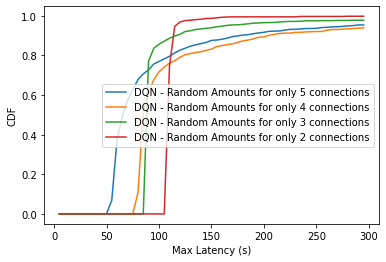

In [ ]:
plt.plot(stats22,dqn_cdf22)
plt.plot(stats22,dqn_cdf_4_conn)
plt.plot(stats22,dqn_cdf_3_conn)
plt.plot(stats22,dqn_cdf_2_conn)
plt.xlabel("Max Latency (s)")
plt.ylabel("CDF")
plt.legend(['DQN - Random Amounts for only 5 connections','DQN - Random Amounts for only 4 connections','DQN - Random Amounts for only 3 connections', 'DQN - Random Amounts for only 2 connections'])
plt.show()

In [ ]:
#########################################################################

In [ ]:
print(dict_actions)

{'0': [0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0], '1': [0.0, 0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0], '2': [0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '3': [0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5], '4': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.5], '5': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0], '6': [0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0], '7': [0.0, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.0], '8': [0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '9': [0.0, 0.0, 0.0, 0.0, 0.5, 0.5, 0.0, 0.0, 0.0, 0.0]}


In [ ]:
print(dict_actions)

{'0': [0.0, 0.0, 0.52401754, 0.47598246, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '1': [0.0, 0.73175478, 0.26824522, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '2': [0.0, 0.17128827, 0.0, 0.0, 0.0, 0.0, 0.82871173, 0.0, 0.0, 0.0], '3': [0.67593495, 0.0, 0.32406505, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], '4': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.46805536, 0.0, 0.0, 0.53194464], '5': [0.0, 0.82117362, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.17882638], '6': [0.0, 0.0, 0.0, 0.0, 0.0, 0.48705381, 0.51294619, 0.0, 0.0, 0.0], '7': [0.0, 0.0, 0.0, 0.0, 0.48747732, 0.51252268, 0.0, 0.0, 0.0, 0.0], '8': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.45405668, 0.0, 0.54594332, 0.0], '9': [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4212056, 0.0, 0.5787944, 0.0]}


In [ ]:
print(epsilon_greedy_frames)

100000


In [ ]:
#Equal amounts for connect to 2 for 10 APs - without sahdow fading
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.9049049  0.97797798 0.99199199 0.995996
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]


In [ ]:
dqn_cdf_equal = [0.    ,     0. ,        0.  ,       0.       ,  0.,         0.,
 0.   ,      0.   ,      0.      ,   0.      ,   0.,         0.,
 0.   ,      0.   ,      0.      ,   0.      ,   0. ,        0.,
 0.   ,      0.   ,      0.9049049,  0.97797798, 0.99199199, 0.995996,
 1.   ,      1.   ,      1.       ,  1.       ,  1. ,        1.,
 1.   ,      1.   ,      1.       ,  1.      ,   1.  ,       1.,
 1.   ,      1.   ,      1.       ,  1.      ,   1.   ,      1.,
 1.   ,      1.   ,      1.       ,  1.      ,   1.    ,     1.,
 1.   ,      1.   ,      1.       ,  1.      ,   1.      ,   1.,
 1.   ,      1.   ,      1.       ,  1.      ,   1.        ]

In [ ]:
#Random amounts for connect to 2 for 10 APs - without sahdow fading
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.81981982 0.98398398 0.99499499 0.998999
 0.998999   0.998999   1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]


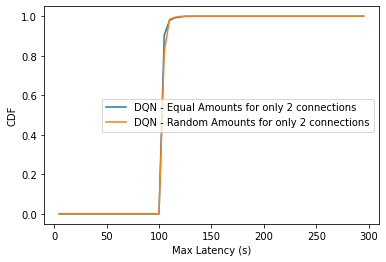

In [ ]:

plt.plot(stats22,dqn_cdf_equal)
plt.plot(stats22,dqn_cdf22)
plt.xlabel("Max Latency (s)")
plt.ylabel("CDF")
plt.legend(['DQN - Equal Amounts for only 2 connections', 'DQN - Random Amounts for only 2 connections'])
plt.show()

In [ ]:
######################################

In [ ]:
# Equal amounts for connect to 2 for 10 APs
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.7027027  0.82782783 0.88288288 0.90590591
 0.93193193 0.94694695 0.95795796 0.96496496 0.96896897 0.97297297
 0.97797798 0.98198198 0.98398398 0.98798799 0.98898899 0.99099099
 0.99199199 0.99399399 0.99399399 0.99499499 0.995996   0.995996
 0.995996   0.995996   0.995996   0.995996   0.995996   0.996997
 0.996997   0.997998   0.998999   0.998999   0.998999   0.998999
 0.998999   0.998999   0.998999   0.998999   0.998999  ]


In [ ]:
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.7027027  0.82782783 0.88288288 0.90590591
 0.93193193 0.94694695 0.95795796 0.96496496 0.96896897 0.97297297
 0.97797798 0.98198198 0.98398398 0.98798799 0.98898899 0.99099099
 0.99199199 0.99399399 0.99399399 0.99499499 0.995996   0.995996
 0.995996   0.995996   0.995996   0.995996   0.995996   0.996997
 0.996997   0.997998   0.998999   0.998999   0.998999   0.998999
 0.998999   0.998999   0.998999   0.998999   0.998999  ]


In [ ]:

# Random amounts for connect to 2 for 10 APs
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.74674675 0.94694695 0.96896897
 0.97597598 0.97797798 0.98098098 0.98298298 0.98698699 0.98698699
 0.98998999 0.99299299 0.99399399 0.99499499 0.99499499 0.99499499
 0.99499499 0.99499499 0.99499499 0.99499499 0.99499499 0.99499499
 0.99499499 0.99499499 0.99499499 0.99499499 0.996997   0.996997
 0.996997   0.996997   0.996997   0.996997   0.996997   0.996997
 0.996997   0.997998   0.997998   0.997998   0.997998  ]


In [ ]:
dqn_cdf_random = [0. ,        0. ,        0.  ,       0.      ,   0. ,        0.,
 0.      ,   0.     ,    0.      ,   0.      ,   0.,         0.,
 0.      ,   0.     ,    0.     ,    0.       ,  0.,         0.,
 0.      ,   0.      ,   0.    ,     0.74674675, 0.94694695, 0.96896897,
 0.97597598, 0.97797798, 0.98098098, 0.98298298, 0.98698699, 0.98698699,
 0.98998999, 0.99299299, 0.99399399, 0.99499499, 0.99499499, 0.99499499,
 0.99499499, 0.99499499, 0.99499499, 0.99499499, 0.99499499, 0.99499499,
 0.99499499, 0.99499499, 0.99499499, 0.99499499, 0.996997,   0.996997,
 0.996997 ,  0.996997 ,  0.996997,   0.996997,   0.996997,   0.996997,
 0.996997 ,  0.997998 ,  0.997998 ,  0.997998,   0.997998  ]

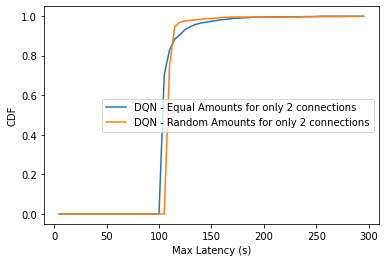

In [ ]:

plt.plot(stats22,dqn_cdf22)
plt.plot(stats22,dqn_cdf_random)
plt.xlabel("Max Latency (s)")
plt.ylabel("CDF")
plt.legend(['DQN - Equal Amounts for only 2 connections', 'DQN - Random Amounts for only 2 connections'])
plt.show()

In [ ]:
########################################

In [ ]:
##10 APs - shadow fad - epsilon_greedy_frames:100000
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.46646647
 0.59359359 0.65065065 0.68368368 0.71671672 0.73573574 0.74774775
 0.75875876 0.77377377 0.79079079 0.8018018  0.80980981 0.81681682
 0.82482482 0.83083083 0.83683684 0.84384384 0.84884885 0.85585586
 0.86386386 0.86686687 0.87387387 0.87887888 0.88288288 0.88488488
 0.88688689 0.89489489 0.8988989  0.8998999  0.9009009  0.9019019
 0.9039039  0.90590591 0.90890891 0.91191191 0.91391391 0.91491491
 0.91491491 0.91691692 0.91891892 0.92092092 0.92092092 0.92192192
 0.92592593 0.92692693 0.92692693 0.92792793 0.92892893]


In [ ]:
##10 APs - shadow fad - epsilon_greedy_frames:100000
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.46646647
 0.59359359 0.65065065 0.68368368 0.71671672 0.73573574 0.74774775
 0.75875876 0.77377377 0.79079079 0.8018018  0.80980981 0.81681682
 0.82482482 0.83083083 0.83683684 0.84384384 0.84884885 0.85585586
 0.86386386 0.86686687 0.87387387 0.87887888 0.88288288 0.88488488
 0.88688689 0.89489489 0.8988989  0.8998999  0.9009009  0.9019019
 0.9039039  0.90590591 0.90890891 0.91191191 0.91391391 0.91491491
 0.91491491 0.91691692 0.91891892 0.92092092 0.92092092 0.92192192
 0.92592593 0.92692693 0.92692693 0.92792793 0.92892893]


In [ ]:
##10 APs - shadow fad - epsilon_greedy_frames:10000
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.21121121 0.46546547 0.57057057 0.64364364 0.68068068 0.70870871
 0.72972973 0.75375375 0.77277277 0.7967968  0.81081081 0.82582583
 0.83783784 0.84484484 0.85285285 0.85685686 0.86086086 0.86586587
 0.87187187 0.87687688 0.88288288 0.88688689 0.89189189 0.8968969
 0.8998999  0.90790791 0.90890891 0.91191191 0.91491491 0.91691692
 0.92192192 0.92492492 0.92792793 0.93093093 0.93393393 0.93393393
 0.93493493 0.93493493 0.93693694 0.93693694 0.93993994 0.94094094
 0.94194194 0.94294294 0.94494494 0.94894895 0.95195195]


In [ ]:
#10000
dqn_cdf_2 = [0.     ,    0.   ,      0.    ,     0.  ,       0.,         0.,
 0.   ,      0.      ,   0.     ,    0.    ,     0.    ,     0.,
 0.21121121, 0.46546547, 0.57057057, 0.64364364, 0.68068068, 0.70870871,
 0.72972973, 0.75375375, 0.77277277, 0.7967968,  0.81081081, 0.82582583,
 0.83783784, 0.84484484, 0.85285285, 0.85685686, 0.86086086, 0.86586587,
 0.87187187, 0.87687688, 0.88288288, 0.88688689, 0.89189189, 0.8968969,
 0.8998999,  0.90790791, 0.90890891, 0.91191191, 0.91491491, 0.91691692,
 0.92192192, 0.92492492, 0.92792793, 0.93093093, 0.93393393, 0.93393393,
 0.93493493, 0.93493493, 0.93693694, 0.93693694, 0.93993994, 0.94094094,
 0.94194194, 0.94294294, 0.94494494, 0.94894895, 0.95195195]

In [ ]:
##10 APs - shadow fad - epsilon_greedy_frames:1000 re-do
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.07507508 0.28028028 0.35935936 0.41341341
 0.46046046 0.5015015  0.53153153 0.56356356 0.58058058 0.6046046
 0.62962963 0.64964965 0.66166166 0.67167167 0.68268268 0.6956957
 0.70870871 0.72072072 0.73373373 0.73973974 0.74874875 0.75775776
 0.76176176 0.76476476 0.77277277 0.78278278 0.79279279 0.7957958
 0.8038038  0.81181181 0.81681682 0.81781782 0.82182182 0.82782783
 0.83183183 0.83683684 0.84684685 0.84884885 0.85085085 0.85385385
 0.85985986 0.86286286 0.86386386 0.86886887 0.87587588 0.87687688
 0.87987988 0.87987988 0.88088088 0.88388388 0.88488488]


In [ ]:
#10 APs - shadow fad - epsilon_greedy_frames:1000
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.07507508 0.28028028 0.35935936 0.41341341
 0.46046046 0.5015015  0.53153153 0.56356356 0.58058058 0.6046046
 0.62962963 0.64964965 0.66166166 0.67167167 0.68268268 0.6956957
 0.70870871 0.72072072 0.73373373 0.73973974 0.74874875 0.75775776
 0.76176176 0.76476476 0.77277277 0.78278278 0.79279279 0.7957958
 0.8038038  0.81181181 0.81681682 0.81781782 0.82182182 0.82782783
 0.83183183 0.83683684 0.84684685 0.84884885 0.85085085 0.85385385
 0.85985986 0.86286286 0.86386386 0.86886887 0.87587588 0.87687688
 0.87987988 0.87987988 0.88088088 0.88388388 0.88488488]


In [ ]:
#1000
dqn_cdf_3 = [0.       ,  0.   ,      0.       ,  0.       ,  0.        , 0.,
 0.     ,    0.        , 0.07507508, 0.28028028, 0.35935936, 0.41341341,
 0.46046046, 0.5015015 , 0.53153153, 0.56356356, 0.58058058, 0.6046046,
 0.62962963, 0.64964965, 0.66166166, 0.67167167, 0.68268268, 0.6956957,
 0.70870871, 0.72072072, 0.73373373, 0.73973974, 0.74874875, 0.75775776,
 0.76176176, 0.76476476, 0.77277277, 0.78278278, 0.79279279, 0.7957958,
 0.8038038,  0.81181181, 0.81681682, 0.81781782, 0.82182182, 0.82782783,
 0.83183183, 0.83683684, 0.84684685, 0.84884885, 0.85085085, 0.85385385,
 0.85985986, 0.86286286, 0.86386386, 0.86886887, 0.87587588, 0.87687688,
 0.87987988, 0.87987988, 0.88088088 ,0.88388388, 0.88488488]

In [ ]:
#10 APs - shadow fad - epsilon_greedy_frames:100
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.21121121 0.46546547 0.57057057 0.64364364 0.68068068 0.70870871
 0.72972973 0.75375375 0.77277277 0.7967968  0.81081081 0.82582583
 0.83783784 0.84484484 0.85285285 0.85685686 0.86086086 0.86586587
 0.87187187 0.87687688 0.88288288 0.88688689 0.89189189 0.8968969
 0.8998999  0.90790791 0.90890891 0.91191191 0.91491491 0.91691692
 0.92192192 0.92492492 0.92792793 0.93093093 0.93393393 0.93393393
 0.93493493 0.93493493 0.93693694 0.93693694 0.93993994 0.94094094
 0.94194194 0.94294294 0.94494494 0.94894895 0.95195195]


In [ ]:
#100 
dqn_cdf_4 = [0.    ,     0.   ,      0.    ,     0.    ,     0.,         0.,
 0.   ,      0.    ,     0.     ,    0.    ,     0.      ,   0.,
 0.21121121, 0.46546547, 0.57057057, 0.64364364, 0.68068068, 0.70870871,
 0.72972973, 0.75375375, 0.77277277, 0.7967968 , 0.81081081, 0.82582583,
 0.83783784, 0.84484484, 0.85285285, 0.85685686, 0.86086086, 0.86586587,
 0.87187187, 0.87687688, 0.88288288, 0.88688689, 0.89189189, 0.8968969,
 0.8998999 , 0.90790791, 0.90890891, 0.91191191, 0.91491491, 0.91691692,
 0.92192192, 0.92492492, 0.92792793, 0.93093093, 0.93393393, 0.93393393,
 0.93493493, 0.93493493, 0.93693694, 0.93693694, 0.93993994, 0.94094094,
 0.94194194 ,0.94294294, 0.94494494, 0.94894895, 0.95195195]

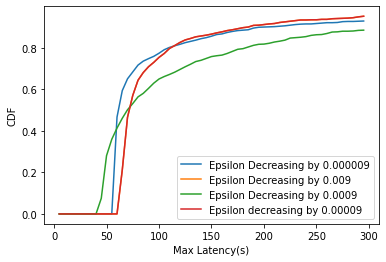

In [ ]:

#plt.xlim(0, 70)
plt.plot(stats22,dqn_cdf22)
plt.plot(stats22,dqn_cdf_4)
plt.plot(stats22,dqn_cdf_3)
plt.plot(stats22,dqn_cdf_2)
plt.xlabel("Max Latency(s)")
plt.ylabel("CDF")
plt.legend(['Epsilon Decreasing by 0.000009', 'Epsilon Decreasing by 0.009', 'Epsilon Decreasing by 0.0009', 'Epsilon decreasing by 0.00009'])
plt.show()

In [ ]:
########################################

In [ ]:
#10 APs - epsilon_greedy_frames:100
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.001001   0.45745746 0.65965966 0.73873874
 0.77677678 0.82782783 0.85785786 0.87587588 0.89289289 0.9029029
 0.91291291 0.91991992 0.92692693 0.93393393 0.93993994 0.94894895
 0.95495495 0.96096096 0.96796797 0.97097097 0.97597598 0.98198198
 0.98298298 0.98398398 0.98698699 0.98798799 0.98898899 0.98898899
 0.99099099 0.99199199 0.99199199 0.99299299 0.99299299 0.99299299
 0.99499499 0.99499499 0.99499499 0.99499499 0.995996   0.995996
 0.995996   0.996997   0.996997   0.996997   0.996997   0.996997
 0.996997   0.996997   0.996997   0.996997   0.996997  ]


In [ ]:
#10 APs - epsilon_greedy_frames:10000
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.001001   0.45745746 0.65965966 0.73873874
 0.77677678 0.82782783 0.85785786 0.87587588 0.89289289 0.9029029
 0.91291291 0.91991992 0.92692693 0.93393393 0.93993994 0.94894895
 0.95495495 0.96096096 0.96796797 0.97097097 0.97597598 0.98198198
 0.98298298 0.98398398 0.98698699 0.98798799 0.98898899 0.98898899
 0.99099099 0.99199199 0.99199199 0.99299299 0.99299299 0.99299299
 0.99499499 0.99499499 0.99499499 0.99499499 0.995996   0.995996
 0.995996   0.996997   0.996997   0.996997   0.996997   0.996997
 0.996997   0.996997   0.996997   0.996997   0.996997  ]


In [ ]:
dqn_cdf_4 = [0.   ,      0.     ,    0.       ,  0.  ,       0.        , 0.,
 0.    ,     0.        , 0.001001 ,  0.45745746 ,0.65965966, 0.73873874,
 0.77677678, 0.82782783, 0.85785786, 0.87587588 ,0.89289289 ,0.9029029,
 0.91291291, 0.91991992, 0.92692693, 0.93393393 ,0.93993994 ,0.94894895,
 0.95495495, 0.96096096, 0.96796797, 0.97097097 ,0.97597598 ,0.98198198,
 0.98298298, 0.98398398, 0.98698699, 0.98798799 ,0.98898899 ,0.98898899,
 0.99099099, 0.99199199, 0.99199199, 0.99299299 ,0.99299299 ,0.99299299,
 0.99499499, 0.99499499, 0.99499499, 0.99499499 ,0.995996   ,0.995996,
 0.995996 ,  0.996997 ,  0.996997 ,  0.996997  , 0.996997   ,0.996997,
 0.996997 ,  0.996997,   0.996997 ,  0.996997 ,  0.996997  ]
[ ]


[]

In [ ]:
#10 APs - epsilon_greedy_frames:1000
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.001001   0.45745746 0.65965966 0.73873874
 0.77677678 0.82782783 0.85785786 0.87587588 0.89289289 0.9029029
 0.91291291 0.91991992 0.92692693 0.93393393 0.93993994 0.94894895
 0.95495495 0.96096096 0.96796797 0.97097097 0.97597598 0.98198198
 0.98298298 0.98398398 0.98698699 0.98798799 0.98898899 0.98898899
 0.99099099 0.99199199 0.99199199 0.99299299 0.99299299 0.99299299
 0.99499499 0.99499499 0.99499499 0.99499499 0.995996   0.995996
 0.995996   0.996997   0.996997   0.996997   0.996997   0.996997
 0.996997   0.996997   0.996997   0.996997   0.996997  ]


In [ ]:
dqn_cdf_2 = [0.      ,   0.   ,      0.       ,  0. ,        0. ,        0.,
 0.       ,  0.       ,  0.001001,   0.45745746, 0.65965966, 0.73873874,
 0.77677678, 0.82782783, 0.85785786 ,0.87587588, 0.89289289, 0.9029029,
 0.91291291, 0.91991992, 0.92692693, 0.93393393, 0.93993994, 0.94894895,
 0.95495495, 0.96096096, 0.96796797, 0.97097097, 0.97597598, 0.98198198,
 0.98298298, 0.98398398, 0.98698699, 0.98798799, 0.98898899, 0.98898899,
 0.99099099, 0.99199199, 0.99199199, 0.99299299, 0.99299299, 0.99299299,
 0.99499499, 0.99499499, 0.99499499, 0.99499499, 0.995996,   0.995996,
 0.995996 ,  0.996997 ,  0.996997,   0.996997 ,  0.996997,   0.996997,
 0.996997 ,  0.996997 ,  0.996997,   0.996997,   0.996997  ]

In [ ]:
#10 APs - epsilon_greedy_frames: 100000
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.64564565 0.91391391 0.96396396
 0.97897898 0.98698699 0.99099099 0.99299299 0.995996   0.995996
 0.995996   0.996997   0.997998   0.997998   1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         1.        ]


In [ ]:
dqn_cdf_3 = [0.  ,       0.    ,     0.    ,     0.   ,      0.      ,   0.,
 0.     ,    0.      ,   0.      ,   0.64564565, 0.91391391, 0.96396396,
 0.97897898, 0.98698699, 0.99099099, 0.99299299, 0.995996,   0.995996,
 0.995996,   0.996997  , 0.997998,   0.997998,   1.  ,       1.,
 1.   ,      1.  ,       1.    ,     1. ,        1.  ,       1.,
 1.   ,      1.  ,       1.   ,      1. ,        1.  ,       1.,
 1.   ,      1.  ,       1.   ,      1. ,        1.  ,       1.,
 1.   ,      1.  ,       1.   ,      1. ,        1.  ,       1.,
 1.   ,      1.  ,       1.  ,       1. ,        1.  ,       1.,
 1.   ,      1.  ,       1.  ,       1. ,        1.        ]

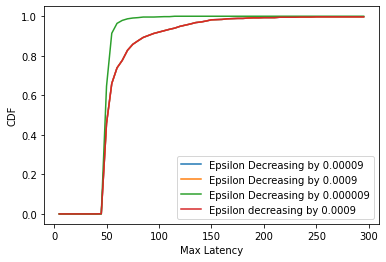

In [ ]:

#plt.xlim(0, 70)
plt.plot(stats22,dqn_cdf_4)
plt.plot(stats22,dqn_cdf_2)
plt.plot(stats22,dqn_cdf_3)
plt.plot(stats22,dqn_cdf22)
plt.xlabel("Max Latency")
plt.ylabel("CDF")
plt.legend(['Epsilon Decreasing by 0.00009', 'Epsilon Decreasing by 0.0009', 'Epsilon Decreasing by 0.000009', 'Epsilon decreasing by 0.0009'])
plt.show()

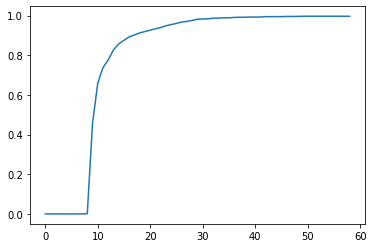

In [ ]:
plt.plot(dqn_cdf_4) # 10000

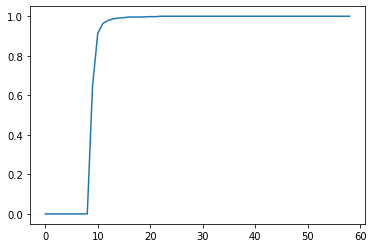

In [ ]:
plt.plot(dqn_cdf_3) #100000

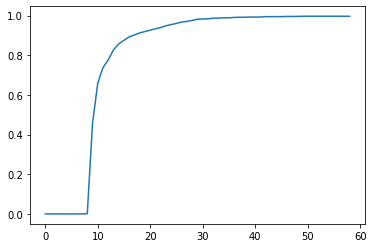

In [ ]:
plt.plot(dqn_cdf_2) #1000

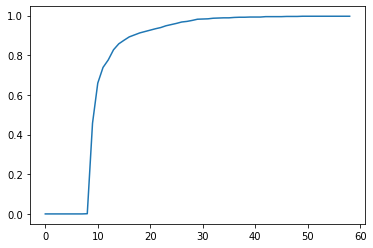

In [ ]:
plt.plot(dqn_cdf22)

In [ ]:
#with seeds
print(dqn_cdf22)

[0.         0.         0.         0.         0.         0.
 0.         0.21521522 0.28828829 0.34834835 0.40540541 0.46346346
 0.51251251 0.55455455 0.58458458 0.61361361 0.64364364 0.67267267
 0.6966967  0.70970971 0.72372372 0.73573574 0.74474474 0.75475475
 0.76576577 0.77277277 0.77977978 0.78378378 0.78678679 0.79479479
 0.8018018  0.80580581 0.81381381 0.81881882 0.82182182 0.82482482
 0.82982983 0.83383383 0.83983984 0.84284284 0.84784785 0.85185185
 0.86186186 0.86886887 0.87087087 0.87487487 0.87487487 0.87787788
 0.87987988 0.88188188 0.88188188 0.88388388 0.88588589 0.88888889
 0.89189189 0.89489489 0.89489489 0.8968969  0.8988989 ]


In [ ]:
print(dqn_cdf)

[0.      0.      0.      0.0984  0.19925 0.29285 0.3571  0.40945 0.45205
 0.4871  0.5156  0.5417  0.56465 0.58485 0.60315 0.62055 0.63655 0.65115
 0.6639  0.6765  0.68775 0.69875 0.70975 0.71855 0.7274  0.73545 0.7427
 0.7499  0.75725 0.76265 0.7686  0.77365 0.7787  0.783   0.78655 0.7907
 0.7953  0.79925 0.80325 0.8071  0.81055 0.8144  0.81795 0.8214  0.82405
 0.82725 0.82945 0.83185 0.8343  0.83675 0.8391  0.8418  0.8437  0.84575
 0.8477  0.84985 0.8517  0.8539  0.8558  0.8575  0.8598  0.86215 0.8637
 0.8655  0.86645 0.8683  0.87015 0.87165 0.8728  0.87445 0.8761  0.87815
 0.8795  0.8809  0.882   0.8829  0.88415 0.88575 0.8868  0.8881  0.8889
 0.88995 0.8907  0.8918  0.8929  0.89415 0.89525 0.89625 0.8971  0.89815
 0.8992  0.9006  0.9009  0.90195 0.9029  0.90375 0.9049  0.90575 0.9067
 0.9076  0.90835 0.9089  0.90945 0.9101  0.9107  0.91145 0.9125  0.9131
 0.9137  0.91425 0.91525 0.9159  0.91675 0.9174  0.91765 0.9184  0.91895
 0.91945 0.91995 0.9204  0.921   0.92145 0.9218  0.92225 

In [ ]:
stats = np.arange(5, 8000000, 5) #3000 #10000000
#stats = np.arange(100, 3000, 100)
ep_cdf =np.zeros([1,len(stats)])[0]
unif_cdf =np.zeros([1,len(stats)])[0]
const_cdf =np.zeros([1,len(stats)])[0]
count = 0
for il in stats:
  tata = len(np.argwhere(ep_reward_list<il))
  tata2 = len(np.argwhere(unif_reward_list<il))
  tata3 = len(np.argwhere(const_reward_list<il))
  ep_cdf[count] = tata/len(ep_reward_list)#999#1000
  unif_cdf[count] = tata2/len(unif_reward_list)#999#1000
  const_cdf[count] = tata3/len(const_reward_list)#999#1000
  count = count + 1

plt.xlim(0, 70)
plt.plot(ep_cdf)
plt.plot(unif_cdf)
plt.plot(const_cdf)
plt.xlabel("Max Latency (s)")
plt.ylabel("CDF")
plt.legend(['Distributed method w/DDPG', 'Uniform Method', 'Best Channel Method'])
plt.show()

KeyboardInterrupt: ignored

In [ ]:
print(len(ep_reward_list))
print(len(testlines))
print(len(const_reward_list))
print(indexxx)
print(actor_lr)
#print(xx1)
#print(xx2)
#print(ep_reward_list)

999
2000
999
2000
0.001


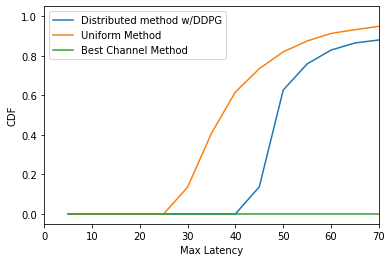

In [ ]:
#stats = np.arange(10, 8000000, 10) #3000 #10000000
stats = np.arange(5, 500, 5)
ep_cdf =np.zeros([1,len(stats)])[0]
unif_cdf =np.zeros([1,len(stats)])[0]
const_cdf =np.zeros([1,len(stats)])[0]
count = 0
for il in stats:
  tata = len(np.argwhere(ep_reward_list<il))
  tata2 = len(np.argwhere(unif_reward_list<il))
  tata3 = len(np.argwhere(const_reward_list<il))
  '''
  ep_cdf[count] = tata/999#1000
  unif_cdf[count] = tata2/999#1000
  const_cdf[count] = tata3/999#1000
  '''
  ep_cdf[count] = tata/(len(ep_reward_list))#999#1000
  unif_cdf[count] = tata2/(len(unif_reward_list))#999#1000
  const_cdf[count] = tata3/(len(const_reward_list))#999#1000
  count = count + 1

plt.xlim(0, 70)
plt.plot(stats,ep_cdf)
plt.plot(stats,unif_cdf)
plt.plot(stats,const_cdf)
plt.xlabel("Max Latency")
plt.ylabel("CDF")
plt.legend(['Distributed method w/DDPG', 'Uniform Method', 'Best Channel Method'])
plt.show()

In [ ]:
#cdf ver 2

print(len(ep_cdf))
print(len(stats))
'''
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

N = len(ep_reward_list)
data = ep_reward_list #np.random.randn(N)
count, bins_count = np.histogram(data, bins=100)
pdf = count / sum(count)
cdf = np.cumsum(pdf)
plt.plot(bins_count[1:], cdf, label="CDF")
plt.legend()
plt.show()
'''

'''
sorted_ddpg = np.sort(ep_reward_list)
sorted_const = np.sort(const_reward_list)
sorted_unif = np.sort(unif_reward_list)
p = 1. * np.arange(len(sorted_ddpg)) / float(len(sorted_ddpg) - 1)
p_const = 1. * np.arange(len(sorted_const)) / float(len(sorted_const) - 1)
p_unif = 1. * np.arange(len(sorted_unif)) / float(len(sorted_unif) - 1)


figure, axis = plt.subplots(2, 2)
  

plot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)
plot2 = plt.subplot2grid((3, 3), (0, 2), rowspan=3, colspan=2)
plot3 = plt.subplot2grid((3, 3), (1, 0), rowspan=2)

plot2.plot(sorted_ddpg, p)
plot2.set_title('DDPG')
  
# Plot for exponent
plot1.plot(sorted_const, p_const)
plot1.set_title('Best Channel')
  
# Plot for Square
plot3.plot(sorted_unif, p_unif)
plot3.set_title('Uniform')
  
# Packing all the plots and displaying them
plt.tight_layout()
plt.show()



#plt.plot(p_const)
#plt.xlabel("Max Latency")
#plt.ylabel("CDF")
#plt.legend(['Distributed method w/DDPG', 'Uniform Method', 'Best Channel Method'])
plt.show()
'''

99
99


'\nsorted_ddpg = np.sort(ep_reward_list)\nsorted_const = np.sort(const_reward_list)\nsorted_unif = np.sort(unif_reward_list)\np = 1. * np.arange(len(sorted_ddpg)) / float(len(sorted_ddpg) - 1)\np_const = 1. * np.arange(len(sorted_const)) / float(len(sorted_const) - 1)\np_unif = 1. * np.arange(len(sorted_unif)) / float(len(sorted_unif) - 1)\n\n\nfigure, axis = plt.subplots(2, 2)\n  \n\nplot1 = plt.subplot2grid((3, 3), (0, 0), colspan=2)\nplot2 = plt.subplot2grid((3, 3), (0, 2), rowspan=3, colspan=2)\nplot3 = plt.subplot2grid((3, 3), (1, 0), rowspan=2)\n\nplot2.plot(sorted_ddpg, p)\nplot2.set_title(\'DDPG\')\n  \n# Plot for exponent\nplot1.plot(sorted_const, p_const)\nplot1.set_title(\'Best Channel\')\n  \n# Plot for Square\nplot3.plot(sorted_unif, p_unif)\nplot3.set_title(\'Uniform\')\n  \n# Packing all the plots and displaying them\nplt.tight_layout()\nplt.show()\n\n\n\n#plt.plot(p_const)\n#plt.xlabel("Max Latency")\n#plt.ylabel("CDF")\n#plt.legend([\'Distributed method w/DDPG\', \'Uni

In [ ]:
print(new_rate)
'''
print(rate[0])
x = rate[0][:]
print(x)
x[6] = 0
print(x)
'''
#print(rate[0])
#print(sum_temp)
#print(sum_den)

'''
print('alphasss_indices')
print(alphasss_indices)
print('Alphas')
print(alphasss)
print('Original rate')
print(rate)
print('New_rate')
print(new_rate)
print('New alphasss')
print(new_alphasss)
'''

####print(actions[0])
###print(actions[1])
#print(sum_temp)
#print(rate[0])
#print(new_rate)
#print(alphasss)
###########print(B*np.log2(1+((sum_temp[0])/(1+sum_den[0]))))

'''
x = B*np.log2(1+((sum_temp[0])/(1+sum_den[0])))
print('rate')
print(x)
print(type(x))
y = x.copy()
print('copy rate')
print(y)
print('new y')
y[6] = 1
print(y)
print('Original x')
print(x)
'''


#print(np.where(actions[0]==0)[0])
#print(np.where(actions[1]==0)[0])
#print(np.where(rate[0]==0)[0])

'''
print(actions[sew])
print(len(product))
print(new_rate)
print(rate[0])
print(new_alphasss)
'''

[]


'\nprint(actions[sew])\nprint(len(product))\nprint(new_rate)\nprint(rate[0])\nprint(new_alphasss)\n'